In [2]:
from __future__ import annotations

import csv, json, math, os, re, traceback
from dataclasses import dataclass
from typing import Any, Dict, List, Optional, Tuple, Union, Set

import FreeCAD  # type: ignore
import Import   # type: ignore
import Part     # type: ignore

Pt2 = Tuple[float, float]

def _safe(obj: Any, attr: str, default: Any = None) -> Any:
    try:
        return getattr(obj, attr)
    except Exception:
        return default

def _truthy_mesh(value: str) -> bool:
    v = (value or "").strip().lower()
    if v in {"1", "true", "yes", "y", "on"}: return True
    if v in {"0", "false", "no", "n", "off", ""}: return False
    try:
        return int(v) != 0
    except Exception:
        return False


In [3]:
@dataclass(frozen=True)
class ComponentSpec:
    parent: str
    subcomponent: str
    material: str
    mesh: bool
    bc: str
    comment: str

def load_component_csv(csv_path: str = "./naming_convention.csv"):
    specs: List[ComponentSpec] = []
    by_bc_material: Dict[str, List[ComponentSpec]] = {}

    with open(csv_path, "r", encoding="utf-8-sig", newline="") as f:
        reader = csv.DictReader(f)
        required = {"Parent", "Subcomponent", "Material", "Mesh", "BC", "Comment"}
        missing = required - set(reader.fieldnames or [])
        if missing:
            raise ValueError(f"CSV missing required columns: {sorted(missing)}. Found: {reader.fieldnames}")

        for row in reader:
            parent = (row.get("Parent") or "").strip()
            sub = (row.get("Subcomponent") or "").strip()
            material = (row.get("Material") or "").strip() or "NA"
            mesh = _truthy_mesh(row.get("Mesh") or "")
            bc = (row.get("BC") or "").strip() or "NA"
            comment = (row.get("Comment") or "").strip()

            if not parent and not sub:
                continue

            spec = ComponentSpec(parent=parent, subcomponent=sub, material=material, mesh=mesh, bc=bc, comment=comment)
            specs.append(spec)

            key = f"{bc}|{material}"
            by_bc_material.setdefault(key, []).append(spec)

    return specs, by_bc_material

def mesh_targets_from_specs(specs: List[ComponentSpec]) -> List[ComponentSpec]:
    return [s for s in specs if s.mesh]


In [4]:
def load_step(step_path: str, doc_name: str = "imported_step") -> Any:
    doc = FreeCAD.newDocument(doc_name)
    Import.insert(step_path, doc.Name)
    doc.recompute()
    return doc

def find_step_root(doc: Any) -> Any:
    root = None
    for o in getattr(doc, "Objects", []) or []:
        if not getattr(o, "InList", []):
            root = o
            break
    if root is None:
        raise RuntimeError("Could not determine STEP root object")
    return root


In [5]:
def build_label_object_index(doc: Any) -> Dict[str, List[Any]]:
    idx: Dict[str, List[Any]] = {}
    seen: set[int] = set()

    def add(obj: Any):
        if obj is None: return
        oid = id(obj)
        if oid in seen: return
        seen.add(oid)

        lab = str(getattr(obj, "Label", "") or "").strip()
        if lab:
            idx.setdefault(lab, []).append(obj)

        try:
            grp = list(getattr(obj, "Group", []))
        except Exception:
            grp = []
        for ch in grp:
            add(ch)

    for o in getattr(doc, "Objects", []) or []:
        try:
            type_id = str(getattr(o, "TypeId", "") or "")
        except Exception:
            type_id = ""

        is_part = (type_id == "App::Part")
        has_shape = False
        if not is_part:
            try:
                sh = getattr(o, "Shape", None)
                has_shape = (sh is not None and not sh.isNull())
            except Exception:
                has_shape = False

        if is_part or has_shape:
            add(o)
        else:
            try:
                grp = list(getattr(o, "Group", []))
            except Exception:
                grp = []
            for ch in grp:
                add(ch)

    return idx

def build_object_subpath_index_from_root(root: Any) -> Dict[Any, str]:
    idx: Dict[Any, str] = {}
    seen: set[int] = set()

    def children(o: Any) -> List[Any]:
        try:
            return list(getattr(o, "Group", [])) or []
        except Exception:
            return []

    def rec(o: Any, chain_tokens: List[str]):
        oid = id(o)
        if oid in seen: return
        seen.add(oid)

        name = str(getattr(o, "Name", "") or "").strip()
        if not name:
            name = str(getattr(o, "Label", "") or "").strip() or "<?>"

        new_chain = chain_tokens + [name]
        idx[o] = ".".join(new_chain) + "."

        for ch in children(o):
            rec(ch, new_chain)

    rec(root, [])
    return idx


In [6]:
def resolve_targets_from_csv_paths(
    doc: Any,
    root: Any,
    step_path: str,
    csv_path: str,
    label_index: Dict[str, List[Any]],
    obj2path: Dict[Any, str],
):
    specs, by_group = load_component_csv(csv_path)
    targets = mesh_targets_from_specs(specs)

    resolved: Dict[str, List[str]] = {}
    unresolved: List[str] = []

    def objs_for_label(sub: str) -> List[Any]:
        if sub in label_index:
            return list(label_index[sub])
        if sub.endswith("***"):
            prefix = sub[:-3]
            out: List[Any] = []
            for lab, lst in label_index.items():
                if lab.startswith(prefix):
                    out.extend(lst)
            return out
        return []

    for t in targets:
        sub = (t.subcomponent or "").strip()
        objs = objs_for_label(sub) if sub else []
        paths: List[str] = []
        for o in objs:
            p = obj2path.get(o)
            if p:
                paths.append(p)

        # de-dup preserve order
        seenp: set[str] = set()
        paths_unique: List[str] = []
        for p in paths:
            if p not in seenp:
                seenp.add(p)
                paths_unique.append(p)

        resolved[sub] = paths_unique
        if not paths_unique:
            unresolved.append(sub)

    print(f"STEP: {os.path.abspath(step_path)}")
    print(f"CSV:  {os.path.abspath(csv_path)}")
    print(f"Mesh targets (CSV): {len(targets)}")
    print(f"Resolved targets:   {sum(1 for k in resolved if resolved[k])} labels")
    print(f"Unresolved targets: {len(unresolved)} labels")

    return targets, resolved, unresolved, specs, by_group


In [7]:
def ensure_path(p: str) -> str:
    p = (p or "").strip()
    return p if p.endswith(".") else p + "."

def inspect_subobject(root: Any, subpath: str):
    sp = ensure_path(subpath)

    mat = FreeCAD.Matrix()
    obj = root.getSubObject(sp, matrix=mat, transform=True)

    info = {
        "subpath": sp,
        "obj_type": type(obj).__name__ if obj is not None else None,
        "obj_label": str(_safe(obj, "Label", "")) if obj is not None else "",
        "obj_name": str(_safe(obj, "Name", "")) if obj is not None else "",
        "obj_typeid": str(_safe(obj, "TypeId", "")) if obj is not None else "",
        "matrix_arg": mat,   # mutated by getSubObject when matrix=... is supported
        "retType3": None,
    }

    # Try accumulated placement (retType=3)
    try:
        pl = root.getSubObject(sp, retType=3)
        info["retType3"] = pl
        if pl is not None and hasattr(pl, "toMatrix"):
            info["retType3_matrix"] = pl.toMatrix()
    except Exception as e:
        info["retType3_error"] = repr(e)

    return obj, info


In [8]:
STEP_PATH = "./geometry/createGeometryFromCAD/XENT-TPC_20250428.STEP"
CSV_PATH  = "./geometry/createGeometryFromCAD/naming_convention.csv"   # or an absolute path

doc = load_step(STEP_PATH, doc_name="nb_step")
root = find_step_root(doc)

label_index = build_label_object_index(doc)
obj2path = build_object_subpath_index_from_root(root)

targets, resolved, unresolved, specs, by_group = resolve_targets_from_csv_paths(
    doc=doc,
    root=root,
    step_path=STEP_PATH,
    csv_path=CSV_PATH,
    label_index=label_index,
    obj2path=obj2path,
)

# Choose one resolved label and one instance path for debugging:
some_label = next(k for k,v in resolved.items() if v)   # first label that has paths
some_path  = resolved[some_label][0]

obj, info = inspect_subobject(root, some_path)
info

STEP: /work/geometry/createGeometryFromCAD/XENT-TPC_20250428.STEP
CSV:  /work/geometry/createGeometryFromCAD/naming_convention.csv
Mesh targets (CSV): 89
Resolved targets:   87 labels
Unresolved targets: 0 labels


{'subpath': 'XENT_TPC_20250428.XENT_TPC_A_Warm.Part__Feature.',
 'obj_type': None,
 'obj_label': '',
 'obj_name': '',
 'obj_typeid': '',
 'matrix_arg': Matrix ((1,0,0,0),(0,1,0,0),(0,0,1,0),(0,0,0,1)),
 'retType3': None}

In [9]:
# Build a flat list of all resolved (label, subpath) instances
instances = []
for label, paths in resolved.items():
    for sp in (paths or []):
        instances.append({"label": label, "subpath": ensure_path(sp)})

# Sort for stable indexing
instances.sort(key=lambda d: (d["label"], d["subpath"]))

print(f"Total resolved instances: {len(instances)}")

# Show a compact index (first N by default)
def show_instances(n: int = 50, start: int = 0):
    end = min(start + n, len(instances))
    for i in range(start, end):
        print(f"[{i:5d}] {instances[i]['label']}  ::  {instances[i]['subpath']}")
    if end < len(instances):
        print(f"... ({len(instances)-end} more; use show_instances(n=..., start=...))")

show_instances()


Total resolved instances: 672
[    0] XENT-TPC-A11_Warm***  ::  XENT_TPC_20250428.XENT_TPC_A_Warm.Part__Feature123.
[    1] XENT-TPC-A11_Warm***  ::  XENT_TPC_20250428.XENT_TPC_A_Warm.Part__Feature124.
[    2] XENT-TPC-A11_Warm***  ::  XENT_TPC_20250428.XENT_TPC_A_Warm.Part__Feature125.
[    3] XENT-TPC-A11_Warm***  ::  XENT_TPC_20250428.XENT_TPC_A_Warm.Part__Feature126.
[    4] XENT-TPC-A11_Warm***  ::  XENT_TPC_20250428.XENT_TPC_A_Warm.Part__Feature127.
[    5] XENT-TPC-A11_Warm***  ::  XENT_TPC_20250428.XENT_TPC_A_Warm.Part__Feature128.
[    6] XENT-TPC-A11_Warm***  ::  XENT_TPC_20250428.XENT_TPC_A_Warm.Part__Feature129.
[    7] XENT-TPC-A11_Warm***  ::  XENT_TPC_20250428.XENT_TPC_A_Warm.Part__Feature130.
[    8] XENT-TPC-A11_Warm***  ::  XENT_TPC_20250428.XENT_TPC_A_Warm.Part__Feature131.
[    9] XENT-TPC-A11_Warm***  ::  XENT_TPC_20250428.XENT_TPC_A_Warm.Part__Feature132.
[   10] XENT-TPC-A11_Warm***  ::  XENT_TPC_20250428.XENT_TPC_A_Warm.Part__Feature133.
[   11] XENT-TPC-A11_War

In [10]:
def _matrix_apply_to_point(m: FreeCAD.Matrix, v: FreeCAD.Vector) -> FreeCAD.Vector:
    # FreeCAD.Matrix has multiply() in most builds; fallback to manual if needed.
    mul = getattr(m, "multiply", None)
    if callable(mul):
        return mul(v)
    # Manual multiplication using m.A..m.D style is not consistent across builds;
    # if multiply() isn't available, we return the input to avoid misleading output.
    return v

def _basis_reference_from_matrix(m: FreeCAD.Matrix):
    o = _matrix_apply_to_point(m, FreeCAD.Vector(0, 0, 0))
    ex = _matrix_apply_to_point(m, FreeCAD.Vector(1, 0, 0))
    ey = _matrix_apply_to_point(m, FreeCAD.Vector(0, 1, 0))
    ez = _matrix_apply_to_point(m, FreeCAD.Vector(0, 0, 1))
    return {
        "origin_xyz": (float(o.x), float(o.y), float(o.z)),
        "ex_xyz":     (float(ex.x), float(ex.y), float(ex.z)),
        "ey_xyz":     (float(ey.x), float(ey.y), float(ey.z)),
        "ez_xyz":     (float(ez.x), float(ez.y), float(ez.z)),
    }

def _placement_reference(pl: Any):
    out = {"placement": None, "matrix": None, "basis": None}
    if pl is None:
        return out
    out["placement"] = str(pl)
    if hasattr(pl, "toMatrix"):
        try:
            m = pl.toMatrix()
            out["matrix"] = m
            out["basis"] = _basis_reference_from_matrix(m)
        except Exception as e:
            out["matrix_error"] = repr(e)
    return out

def evaluate_instance_transforms(root: Any, subpath: str):
    sp = ensure_path(subpath)

    results: Dict[str, Any] = {"subpath": sp}

    # 1) object resolution + accumulated matrix via getSubObject(..., matrix=..., transform=True)
    mat = FreeCAD.Matrix()
    try:
        obj = root.getSubObject(sp, matrix=mat, transform=True)
        results["getSubObject"] = {
            "obj_type": type(obj).__name__ if obj is not None else None,
            "obj_typeid": str(_safe(obj, "TypeId", "")) if obj is not None else "",
            "obj_name": str(_safe(obj, "Name", "")) if obj is not None else "",
            "obj_label": str(_safe(obj, "Label", "")) if obj is not None else "",
        }
        results["getSubObject_matrix"] = mat
        results["getSubObject_basis"] = _basis_reference_from_matrix(mat)
    except Exception as e:
        results["getSubObject_error"] = repr(e)
        obj = None

    # 2) accumulated placement via retType=3 (if supported)
    try:
        pl3 = root.getSubObject(sp, retType=3)
        results["retType3"] = _placement_reference(pl3)
    except Exception as e:
        results["retType3_error"] = repr(e)

    # 3) object-local placement + global placement methods (not instance-aware for Links, but record anyway)
    if obj is not None:
        try:
            if hasattr(obj, "Placement"):
                results["obj_Placement"] = _placement_reference(obj.Placement)
        except Exception as e:
            results["obj_Placement_error"] = repr(e)

        for meth_name in ("getGlobalPlacement", "globalPlacement", "getGlobalTransform"):
            meth = getattr(obj, meth_name, None)
            if callable(meth):
                try:
                    gp = meth()
                    results[meth_name] = _placement_reference(gp)
                except Exception as e:
                    results[meth_name + "_error"] = repr(e)

    # 4) If obj is a Link: resolve final linked object + matrix (link-chain transform)
    if obj is not None:
        typeid = str(_safe(obj, "TypeId", ""))
        if "App::Link" in typeid or typeid == "App::Link":
            link_mat = FreeCAD.Matrix()
            try:
                base = obj.getLinkedObject(recurse=True, mat=link_mat, transform=True)
                results["getLinkedObject"] = {
                    "base_type": type(base).__name__ if base is not None else None,
                    "base_typeid": str(_safe(base, "TypeId", "")) if base is not None else "",
                    "base_name": str(_safe(base, "Name", "")) if base is not None else "",
                    "base_label": str(_safe(base, "Label", "")) if base is not None else "",
                    "link_LinkTransform": _safe(obj, "LinkTransform", None),
                    "link_LinkPlacement": str(_safe(obj, "LinkPlacement", None)),
                }
                results["getLinkedObject_matrix"] = link_mat
                results["getLinkedObject_basis"] = _basis_reference_from_matrix(link_mat)
            except Exception as e:
                results["getLinkedObject_error"] = repr(e)

    return results

# ---- selection helpers ----

def pick_instance(i: int):
    if i < 0 or i >= len(instances):
        raise IndexError(f"Index {i} out of range 0..{len(instances)-1}")
    return instances[i]["label"], instances[i]["subpath"]

# Choose an index from show_instances output:
i = 0  # <-- change this
label, sp = pick_instance(i)

print("Selected:")
print("  index :", i)
print("  label :", label)
print("  path  :", sp)

res = evaluate_instance_transforms(root, sp)

# Print the most useful reference coordinates for quick comparison:
print("\nReference coords (matrix-based):")
if "getSubObject_basis" in res:
    print("  getSubObject(matrix=..., transform=True):", res["getSubObject_basis"])
if "retType3" in res and isinstance(res["retType3"], dict) and res["retType3"].get("basis"):
    print("  retType=3 Placement basis:", res["retType3"]["basis"])
if "getLinkedObject_basis" in res:
    print("  getLinkedObject(..., mat=..., transform=True):", res["getLinkedObject_basis"])

# Full raw results dict if you want to inspect everything:
res


Selected:
  index : 0
  label : XENT-TPC-A11_Warm***
  path  : XENT_TPC_20250428.XENT_TPC_A_Warm.Part__Feature123.

Reference coords (matrix-based):
  getSubObject(matrix=..., transform=True): {'origin_xyz': (0.0, 0.0, 0.0), 'ex_xyz': (1.0, 0.0, 0.0), 'ey_xyz': (0.0, 1.0, 0.0), 'ez_xyz': (0.0, 0.0, 1.0)}


{'subpath': 'XENT_TPC_20250428.XENT_TPC_A_Warm.Part__Feature123.',
 'getSubObject': {'obj_type': None,
  'obj_typeid': '',
  'obj_name': '',
  'obj_label': ''},
 'getSubObject_matrix': Matrix ((1,0,0,0),(0,1,0,0),(0,0,1,0),(0,0,0,1)),
 'getSubObject_basis': {'origin_xyz': (0.0, 0.0, 0.0),
  'ex_xyz': (1.0, 0.0, 0.0),
  'ey_xyz': (0.0, 1.0, 0.0),
  'ez_xyz': (0.0, 0.0, 1.0)},
 'retType3': {'placement': None, 'matrix': None, 'basis': None}}

In [11]:
def debug_subpath_resolution(root, sp: str):
    sp = ensure_path(sp)
    toks = [t for t in sp.split(".") if t]  # drop trailing empty
    cur_path = ""
    print("Full tokens:", toks)

    for i, t in enumerate(toks, 1):
        cur_path += t + "."
        mat = FreeCAD.Matrix()
        try:
            obj = root.getSubObject(cur_path, matrix=mat, transform=True)
        except Exception as e:
            obj = None
            print(f"[{i}] {cur_path} -> EXCEPTION: {e!r}")
            break

        if obj is None:
            print(f"[{i}] {cur_path} -> None (resolution stops here)")
            break

        print(f"[{i}] {cur_path} -> {type(obj).__name__}  "
              f"TypeId={_safe(obj,'TypeId','')}  Name={_safe(obj,'Name','')}  Label={_safe(obj,'Label','')}")
    return

debug_subpath_resolution(root, "XENT_TPC_20250428.XENT_TPC_A_Warm.Part__Feature123.")


Full tokens: ['XENT_TPC_20250428', 'XENT_TPC_A_Warm', 'Part__Feature123']
[1] XENT_TPC_20250428. -> None (resolution stops here)


In [12]:
[t for t in "XENT_TPC_20250428.XENT_TPC_A_Warm.Part__Feature123.".split(".") if t]

['XENT_TPC_20250428', 'XENT_TPC_A_Warm', 'Part__Feature123']

In [13]:
print("Root object:")
print("  TypeId :", _safe(root, "TypeId", ""))
print("  Name   :", _safe(root, "Name", ""))
print("  Label  :", _safe(root, "Label", ""))

Root object:
  TypeId : App::Part
  Name   : XENT_TPC_20250428
  Label  : XENT-TPC_20250428


In [14]:
def list_children(obj):
    print(f"\nChildren of {obj.Name} ({obj.TypeId})\n")

    try:
        grp = list(getattr(obj, "Group", []))
    except Exception:
        grp = []

    if not grp:
        print("  (no Group children)")
    else:
        for ch in grp:
            print(f"  Name={_safe(ch,'Name',''):30s} "
                  f"Label={_safe(ch,'Label',''):30s} "
                  f"TypeId={_safe(ch,'TypeId','')}")

list_children(root)


Children of XENT_TPC_20250428 (App::Part)

  Name=XENT_TPC_A_Warm                Label=XENT-TPC-A_Warm                TypeId=App::Part
  Name=XENT_TPC_B_Warm                Label=XENT-TPC-B_Warm                TypeId=App::Part
  Name=XENT_TPC_C_Warm                Label=XENT-TPC-C_Warm                TypeId=App::Part
  Name=XENT_TPC_D_New_Anode           Label=XENT-TPC-D_New_Anode           TypeId=App::Part
  Name=XENT_TPC_E_Plan_B_Warm         Label=XENT-TPC-E_Plan-B Warm         TypeId=App::Part
  Name=XENT_TPC_F                     Label=XENT-TPC-F055                  TypeId=App::Part
  Name=XENT_TPC_G_Warm                Label=XENT-TPC-G_Warm                TypeId=App::Part
  Name=XENT_TPC_H_Warm                Label=XENT-TPC-H_Warm                TypeId=App::Part


In [15]:
def list_children(obj, max_items: int | None = None):
    print(f"\nChildren of {obj.Name} ({obj.TypeId})\n")

    try:
        grp = list(getattr(obj, "Group", []))
    except Exception:
        grp = []

    if not grp:
        print("  (no Group children)")
        return

    if max_items is not None:
        grp = grp[:max_items]

    for ch in grp:
        print(f"  Name={_safe(ch,'Name',''):30s} "
              f"Label={_safe(ch,'Label',''):30s} "
              f"TypeId={_safe(ch,'TypeId','')}")

def get_child_by_name(parent, name: str):
    for ch in getattr(parent, "Group", []) or []:
        if str(getattr(ch, "Name", "")) == name:
            return ch
    return None

# Pick the App::Part you want to inspect:
part_name = "XENT_TPC_A_Warm"   # <-- change this
part = get_child_by_name(root, part_name)

print("Selected part:", part_name, "->", part)
if part is None:
    raise RuntimeError(f"Part {part_name!r} not found under root.Group")

list_children(part)



Selected part: XENT_TPC_A_Warm -> <Part object>

Children of XENT_TPC_A_Warm (App::Part)

  Name=Part__Feature                  Label=XENT-TPC-A1A_Warm              TypeId=Part::Feature
  Name=Part__Feature001               Label=XENT-TPC-A1B_Warm              TypeId=Part::Feature
  Name=Part__Feature002               Label=XENT-TPC-A1A_Warm001           TypeId=Part::Feature
  Name=Part__Feature003               Label=XENT-TPC-A1A_Warm002           TypeId=Part::Feature
  Name=Part__Feature004               Label=XENT-TPC-A1A_Warm003           TypeId=Part::Feature
  Name=Part__Feature005               Label=XENT-TPC-A1A_Warm004           TypeId=Part::Feature
  Name=Part__Feature006               Label=XENT-TPC-A1A_Warm005           TypeId=Part::Feature
  Name=Part__Feature007               Label=XENT-TPC-A1A_Warm006           TypeId=Part::Feature
  Name=Part__Feature008               Label=XENT-TPC-A1A_Warm007           TypeId=Part::Feature
  Name=Part__Feature009               Label=XE

In [18]:

def _matrix_apply_to_point(m: FreeCAD.Matrix, v: FreeCAD.Vector) -> FreeCAD.Vector:
    mul = getattr(m, "multiply", None)
    if callable(mul):
        return mul(v)
    # fallback: if multiply isn't available, don't lie
    raise RuntimeError("FreeCAD.Matrix.multiply(Vector) not available in this build")

def _basis_reference_from_matrix(m: FreeCAD.Matrix):
    o  = _matrix_apply_to_point(m, FreeCAD.Vector(0, 0, 0))
    ex = _matrix_apply_to_point(m, FreeCAD.Vector(1, 0, 0))
    ey = _matrix_apply_to_point(m, FreeCAD.Vector(0, 1, 0))
    ez = _matrix_apply_to_point(m, FreeCAD.Vector(0, 0, 1))
    return {
        "origin_xyz": (float(o.x),  float(o.y),  float(o.z)),
        "ex_xyz":     (float(ex.x), float(ex.y), float(ex.z)),
        "ey_xyz":     (float(ey.x), float(ey.y), float(ey.z)),
        "ez_xyz":     (float(ez.x), float(ez.y), float(ez.z)),
    }

def _placement_to_basis(pl: Any):
    if pl is None or not hasattr(pl, "toMatrix"):
        return None
    try:
        return _basis_reference_from_matrix(pl.toMatrix())
    except Exception as e:
        return {"error": repr(e)}

def _object_summary(o: Any) -> Dict[str, Any]:
    return {
        "py_type": type(o).__name__ if o is not None else None,
        "TypeId":  str(_safe(o, "TypeId", "")) if o is not None else "",
        "Name":    str(_safe(o, "Name", "")) if o is not None else "",
        "Label":   str(_safe(o, "Label", "")) if o is not None else "",
    }

def probe_location_methods(*, root: Any, container: Any, obj: Any):
    """
    root      : top App::Part root (your XENT_TPC_20250428)
    container : the App::Part containing obj (your XENT_TPC_A_Warm)
    obj       : leaf object (your Part::Feature / Part::PartFeature)
    """
    out: Dict[str, Any] = {}
    out["root"] = _object_summary(root)
    out["container"] = _object_summary(container)
    out["object"] = _object_summary(obj)

    # --- Build the correct instance path relative to root ---
    # Since root is already XENT_TPC_20250428, path is: <containerName>.<objName>.
    sp = f"{container.Name}.{obj.Name}."
    out["instance_subpath"] = sp

    # --- (A) getSubObject(matrix=..., transform=True) on the instance path ---
    try:
        mat = FreeCAD.Matrix()
        sobj = root.getSubObject(sp, matrix=mat, transform=True)
        out["getSubObject_instance"] = {
            "resolved_obj": _object_summary(sobj),
            "matrix": mat,
            "basis": _basis_reference_from_matrix(mat),
        }
    except Exception as e:
        out["getSubObject_instance_error"] = repr(e)

    # --- (B) getSubObject(retType=3) on the instance path (if supported) ---
    try:
        pl3 = root.getSubObject(sp, retType=3)
        out["getSubObject_retType3_instance"] = {
            "placement": str(pl3),
            "basis": _placement_to_basis(pl3),
        }
    except Exception as e:
        out["getSubObject_retType3_instance_error"] = repr(e)

    # --- (C) object-local placement properties/methods (may ignore instance context) ---
    try:
        if hasattr(obj, "Placement"):
            out["obj_Placement"] = {
                "placement": str(obj.Placement),
                "basis": _placement_to_basis(obj.Placement),
            }
    except Exception as e:
        out["obj_Placement_error"] = repr(e)

    for meth_name in ("getGlobalPlacement", "globalPlacement"):
        meth = getattr(obj, meth_name, None)
        if callable(meth):
            try:
                gp = meth()
                out[meth_name] = {"placement": str(gp), "basis": _placement_to_basis(gp)}
            except Exception as e:
                out[meth_name + "_error"] = repr(e)

    # --- (D) if obj is an App::Link, resolve linked object + matrix ---
    typeid = str(_safe(obj, "TypeId", ""))
    if "App::Link" in typeid or typeid == "App::Link":
        try:
            link_mat = FreeCAD.Matrix()
            base = obj.getLinkedObject(recurse=True, mat=link_mat, transform=True)
            out["getLinkedObject"] = {
                "base": _object_summary(base),
                "matrix": link_mat,
                "basis": _basis_reference_from_matrix(link_mat),
                "LinkTransform": _safe(obj, "LinkTransform", None),
                "LinkPlacement": str(_safe(obj, "LinkPlacement", None)),
            }
        except Exception as e:
            out["getLinkedObject_error"] = repr(e)

    # --- (E) fallback reference from shape bbox (not a transform, but a coordinate sanity check) ---
    try:
        sh = getattr(obj, "Shape", None)
        if sh is not None and hasattr(sh, "BoundBox") and not sh.isNull():
            bb = sh.BoundBox
            out["shape_bbox_local"] = {
                "xmin": float(bb.XMin), "ymin": float(bb.YMin), "zmin": float(bb.ZMin),
                "xmax": float(bb.XMax), "ymax": float(bb.YMax), "zmax": float(bb.ZMax),
            }
    except Exception as e:
        out["shape_bbox_local_error"] = repr(e)

    return out

# --- Use your objects ---
# root                 = XENT_TPC_20250428 (already)
# container (App::Part)= XENT_TPC_A_Warm
# obj (leaf)           = test_obj

#probe = probe_location_methods(root=root, container=XENT_TPC_A_Warm, obj=test_obj)

# Quick comparison printout (the main thing you want):
#print("Instance subpath:", probe["instance_subpath"])
"""if "getSubObject_instance" in probe:
    print("\ngetSubObject(matrix=..., transform=True) basis:")
    print(probe["getSubObject_instance"]["basis"])
if "getSubObject_retType3_instance" in probe:
    print("\ngetSubObject(retType=3) basis:")
    print(probe["getSubObject_retType3_instance"]["basis"])
if "obj_Placement" in probe:
    print("\nobj.Placement basis:")
    print(probe["obj_Placement"]["basis"])
if "getGlobalPlacement" in probe:
    print("\nobj.getGlobalPlacement() basis:")
    print(probe["getGlobalPlacement"]["basis"])
if "globalPlacement" in probe:
    print("\nobj.globalPlacement() basis:")
    print(probe["globalPlacement"]["basis"])"""

# Full dict if needed:
#probe

'if "getSubObject_instance" in probe:\n    print("\ngetSubObject(matrix=..., transform=True) basis:")\n    print(probe["getSubObject_instance"]["basis"])\nif "getSubObject_retType3_instance" in probe:\n    print("\ngetSubObject(retType=3) basis:")\n    print(probe["getSubObject_retType3_instance"]["basis"])\nif "obj_Placement" in probe:\n    print("\nobj.Placement basis:")\n    print(probe["obj_Placement"]["basis"])\nif "getGlobalPlacement" in probe:\n    print("\nobj.getGlobalPlacement() basis:")\n    print(probe["getGlobalPlacement"]["basis"])\nif "globalPlacement" in probe:\n    print("\nobj.globalPlacement() basis:")\n    print(probe["globalPlacement"]["basis"])'

# Working

### Resolving Names and Labels

In [19]:
def list_children(obj):
    # Make an index of available children 
    try:
        grp = list(getattr(obj, "Group", []))
    except Exception:
        grp = []

    if not grp:
        print(_safe(obj, "Name"), "  (no Group children)")
        return []
    else:
        return [[_safe(ch,'Name',''), _safe(ch,'Label',''), _safe(ch,'TypeId','')] for ch in grp]
# Retrieve a child by name 
def get_child_by_name(parent, name: str):
    for ch in getattr(parent, "Group", []) or []:
        if str(getattr(ch, "Name", "")) == name:
            return ch
    return None

def get_child_by_label(parent, label: str):
    """
    Return the first direct child in parent.Group whose Label matches exactly.
    If you want 'all matches', use get_children_by_label().
    """
    target = (label or "").strip()
    for ch in getattr(parent, "Group", []) or []:
        if str(getattr(ch, "Label", "") or "").strip() == target:
            return ch
    return None

def get_children_by_label(parent, label: str):
    """
    Return all direct children in parent.Group whose Label matches exactly.
    """
    target = (label or "").strip()
    out = []
    for ch in getattr(parent, "Group", []) or []:
        if str(getattr(ch, "Label", "") or "").strip() == target:
            out.append(ch)
    return out

def build_hierarchy_index(root_obj):
    """
    Build a full hierarchical dict-of-dicts from root_obj following .Group.
    Each node stores Name/Label/TypeId and a dict of children.

    Returns:
      {
        "Name": ...,
        "Label": ...,
        "TypeId": ...,
        "Children": {
            <child_name>: <child_node>,
            ...
        }
      }

    Notes:
    - Children are keyed by child.Name for stability/uniqueness.
    - If the same Python object is encountered more than once, it is not expanded twice.
    """
    seen = set()

    def rec(o):
        oid = id(o)
        if oid in seen:
            return {
                "Name": str(_safe(o, "Name", "")),
                "Label": str(_safe(o, "Label", "")),
                "TypeId": str(_safe(o, "TypeId", "")),
                "Children": {},
                "_note": "duplicate_reference_not_expanded",
            }
        seen.add(oid)

        node = {
            "Name": str(_safe(o, "Name", "")),
            "Label": str(_safe(o, "Label", "")),
            "TypeId": str(_safe(o, "TypeId", "")),
            "Children": {},
        }

        try:
            children = list(getattr(o, "Group", []) or [])
        except Exception:
            children = []

        for ch in children:
            ch_name = str(_safe(ch, "Name", "")) or f"<unnamed_{id(ch)}>"
            node["Children"][ch_name] = rec(ch)

        return node

    return rec(root_obj)


In [20]:
# List of ["Name", "Label", type]
first_children = list_children(root)
# Part Object
XENT_TPC_A_Warm = get_child_by_name(root, first_children[0][0])
# List of ["Name", "Label", type]
XENT_TPC_A_Warm_children = list_children(XENT_TPC_A_Warm)
# Part Feature obj
test_obj = get_child_by_name(XENT_TPC_A_Warm, XENT_TPC_A_Warm_children[0][0])

In [21]:
hier = build_hierarchy_index(root)

In [22]:
def _bb_to_dict(bb) -> Dict[str, float]:
    return {
        "xmin": float(bb.XMin), "ymin": float(bb.YMin), "zmin": float(bb.ZMin),
        "xmax": float(bb.XMax), "ymax": float(bb.YMax), "zmax": float(bb.ZMax),
    }

def build_labelpath_to_bbox(root: Any) -> Dict[str, Dict[str, float]]:
    """
    Walk root.Group recursively and build:
      out["LabelA.LabelB.LabelC."] = {"xmin":..., "ymin":..., ...}

    Label path uses dot-separated Labels with a trailing dot.
    If a node has an empty Label, we fall back to its Name for that segment.

    Bounding box strategy:
    - Prefer instance-aware shape: resolve shape via root.getSubObject(instance_name_path)
      and use its BoundBox when it returns a TopoShape (Solid/Shell/etc.)
    - Fallback: use obj.Shape.BoundBox (may be in local frame, but still better than nothing)
    """
    out: Dict[str, Dict[str, float]] = {}
    seen = set()

    def rec(parent: Any, name_tokens: List[str], label_tokens: List[str]):
        try:
            children = list(getattr(parent, "Group", []) or [])
        except Exception:
            children = []

        for ch in children:
            oid = id(ch)
            if oid in seen:
                continue
            seen.add(oid)

            name = str(_safe(ch, "Name", ""))
            label = str(_safe(ch, "Label", "")) or name or f"<unnamed_{oid}>"
            typeid = str(_safe(ch, "TypeId", ""))

            new_name_tokens = name_tokens + ([name] if name else [])
            new_label_tokens = label_tokens + [label]

            # Instance path (Name-based) for getSubObject
            sp = ".".join(new_name_tokens) + "."

            # Label path key for output
            lp = ".".join(new_label_tokens) + "."

            bb_dict = None

            # 1) Try instance-aware shape resolution via root.getSubObject(sp)
            try:
                sub = root.getSubObject(sp)
                if sub is not None and hasattr(sub, "BoundBox"):
                    bb = sub.BoundBox
                    bb_dict = _bb_to_dict(bb)
            except Exception:
                pass

            # 2) Fallback to obj.Shape.BoundBox
            if bb_dict is None:
                try:
                    sh = getattr(ch, "Shape", None)
                    if sh is not None and hasattr(sh, "BoundBox") and not sh.isNull():
                        bb_dict = _bb_to_dict(sh.BoundBox)
                except Exception:
                    pass

            # Store if we got one
            if bb_dict is not None:
                out[lp] = bb_dict

            # Recurse into containers (App::Part etc.)
            # (You can also recurse always; Group is empty for leaves anyway)
            rec(ch, new_name_tokens, new_label_tokens)

    rec(root, [], [])
    return out

labelpath_to_bbox = build_labelpath_to_bbox(root)

print("Entries with bounding boxes:", len(labelpath_to_bbox))

# Example: show a few keys
for k in list(labelpath_to_bbox.keys())[:5]:
    print(k, "->", labelpath_to_bbox[k])


Entries with bounding boxes: 6574
XENT-TPC-A_Warm. -> {'xmin': -724.0435690242778, 'ymin': -1544.875, 'zmin': -724.043569024277, 'xmax': 724.0435690242723, 'ymax': 85.41666666666701, 'zmax': 724.0435690241912}
XENT-TPC-A_Warm.XENT-TPC-A1A_Warm. -> {'xmin': -688.5405599400408, 'ymin': -7.620054353622757, 'zmin': -688.5405599400402, 'xmax': 683.3473283659066, 'ymax': 7.620054353622866, 'zmax': 138.71714573470507}
XENT-TPC-A_Warm.XENT-TPC-A1B_Warm. -> {'xmin': -672.883043535625, 'ymin': -7.6200543536227965, 'zmin': -59.27676561413382, 'xmax': 688.5405599400408, 'ymax': 7.620054353622873, 'zmax': 688.5405599400402}
XENT-TPC-A_Warm.XENT-TPC-A1A_Warm001. -> {'xmin': -688.5405599400408, 'ymin': -29.620054353622756, 'zmin': -688.5405599400402, 'xmax': 683.3473283659066, 'ymax': -14.379945646377134, 'zmax': 138.71714573470507}
XENT-TPC-A_Warm.XENT-TPC-A1A_Warm002. -> {'xmin': -688.5405599400408, 'ymin': -51.620054353622756, 'zmin': -688.5405599400402, 'xmax': 683.3473283659066, 'ymax': -36.3799

In [24]:
import math
import FreeCAD
import Part
import matplotlib.pyplot as plt

def slice_object_shape_with_vertical_plane(obj, angle_deg, origin=(0,0,0), axis="Y", tol=1e-7):
    ox, oy, oz = origin
    a = math.radians(float(angle_deg))
    ax = axis.upper().strip()

    if ax == "Y":
        nx, ny, nz = math.sin(a), 0.0, -math.cos(a)
    elif ax == "Z":
        nx, ny, nz = -math.sin(a), math.cos(a), 0.0
    elif ax == "X":
        nx, ny, nz = 0.0, -math.sin(a), math.cos(a)
    else:
        raise ValueError(f"axis must be 'X','Y','Z' (got {axis!r})")

    plane = Part.Plane(
        FreeCAD.Vector(ox, oy, oz),
        FreeCAD.Vector(nx, ny, nz)
    ).toShape()

    sh = getattr(obj, "Shape", None)
    if sh is None or sh.isNull():
        raise RuntimeError(f"{getattr(obj,'Name','<obj>')} has no valid Shape")

    sec = sh.section(plane)
    if sec is None or sec.isNull():
        return []

    try: sec = sec.removeSplitter()
    except Exception: pass
    try: sec = sec.cleanTolerance(tol)
    except Exception: pass

    return list(getattr(sec, "Edges", [])) or []


def _v3_to_2d_in_vertical_plane(v: FreeCAD.Vector, angle_deg: float, axis: str = "Y"):
    a = math.radians(float(angle_deg))
    ax = axis.upper().strip()

    if ax == "X":
        A  = (1.0, 0.0, 0.0)
        e1 = (0.0, 1.0, 0.0)
        e2 = (0.0, 0.0, 1.0)
    elif ax == "Y":
        A  = (0.0, 1.0, 0.0)
        e1 = (1.0, 0.0, 0.0)
        e2 = (0.0, 0.0, 1.0)
    elif ax == "Z":
        A  = (0.0, 0.0, 1.0)
        e1 = (1.0, 0.0, 0.0)
        e2 = (0.0, 1.0, 0.0)
    else:
        raise ValueError(f"axis must be 'X','Y','Z' (got {axis!r})")

    rx = math.cos(a) * e1[0] + math.sin(a) * e2[0]
    ry = math.cos(a) * e1[1] + math.sin(a) * e2[1]
    rz = math.cos(a) * e1[2] + math.sin(a) * e2[2]

    vx, vy, vz = float(v.x), float(v.y), float(v.z)
    axial = vx * A[0] + vy * A[1] + vz * A[2]
    u = vx * rx + vy * ry + vz * rz
    return (float(u), float(axial))


def sample_edge_points_2d(edges, angle_deg: float, axis: str = "Y", deflection: float = 2.0):
    pts2d = []
    for e in edges:
        try:
            verts = e.discretize(Deflection=float(deflection))
            for v in verts:
                pts2d.append(_v3_to_2d_in_vertical_plane(v, angle_deg=angle_deg, axis=axis))
        except Exception:
            pass
    return pts2d


def plot_slice_edges_in_plane(obj, angle_deg, axis="Y", origin=(0,0,0), tol=1e-7, deflection=2.0):
    edges = slice_object_shape_with_vertical_plane(
        obj=obj,
        angle_deg=angle_deg,
        origin=origin,
        axis=axis,
        tol=tol,
    )
    print("Edges returned:", len(edges))

    pts2d = sample_edge_points_2d(edges, angle_deg=angle_deg, axis=axis, deflection=deflection)
    print("Sampled 2D points:", len(pts2d))

    if not pts2d:
        print("No intersection geometry.")
        return []

    xs = [p[0] for p in pts2d]
    ys = [p[1] for p in pts2d]

    plt.figure()
    plt.scatter(xs, ys, s=2)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.title(f"Section of {getattr(obj,'Name','<obj>')} @ {float(angle_deg):.1f}° axis={axis}")
    plt.xlabel("u (in-plane)")
    plt.ylabel("axial")
    plt.tight_layout()
    plt.show()

    return pts2d

angle_deg  =30
# --- usage (plots AND returns points) ---
pts2d = plot_slice_edges_in_plane(
    obj=root,
    angle_deg=angle_deg,
    axis=axis,
    origin=(0.0, 0.0, 0.0),
    tol=1e-7,
    deflection=2.0
)
pts2d


NameError: name 'axis' is not defined

Total subpaths: 6415
Total section edges: 8047
Null/invalid resolves: 0
Total plotted points: 982554


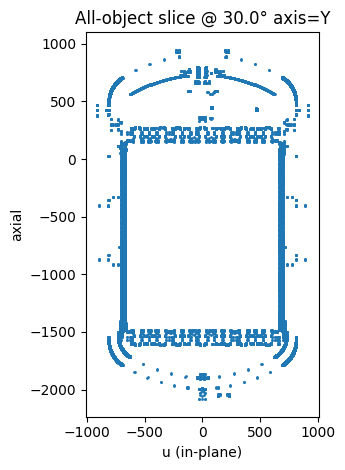

In [28]:
# Slice ALL objects (all Name-subpaths) and plot points in the slicing plane
# Uses the same proven slicing + projection logic as the "full geometry" slice:
# - One plane definition
# - Project with _v3_to_2d_in_vertical_plane
# - Discretize edges and scatter-plot

import math
import FreeCAD
import Part
import matplotlib.pyplot as plt


def _v3_to_2d_in_vertical_plane(v: FreeCAD.Vector, angle_deg: float, axis: str = "Y"):
    a = math.radians(float(angle_deg))
    ax = axis.upper().strip()

    if ax == "X":
        A  = (1.0, 0.0, 0.0)
        e1 = (0.0, 1.0, 0.0)
        e2 = (0.0, 0.0, 1.0)
    elif ax == "Y":
        A  = (0.0, 1.0, 0.0)
        e1 = (1.0, 0.0, 0.0)
        e2 = (0.0, 0.0, 1.0)
    elif ax == "Z":
        A  = (0.0, 0.0, 1.0)
        e1 = (1.0, 0.0, 0.0)
        e2 = (0.0, 1.0, 0.0)
    else:
        raise ValueError(f"axis must be 'X','Y','Z' (got {axis!r})")

    rx = math.cos(a) * e1[0] + math.sin(a) * e2[0]
    ry = math.cos(a) * e1[1] + math.sin(a) * e2[1]
    rz = math.cos(a) * e1[2] + math.sin(a) * e2[2]

    vx, vy, vz = float(v.x), float(v.y), float(v.z)
    axial = vx * A[0] + vy * A[1] + vz * A[2]
    u = vx * rx + vy * ry + vz * rz
    return (float(u), float(axial))


def slice_object_shape_with_vertical_plane(obj, angle_deg, origin=(0,0,0), axis="Y", tol=1e-7):
    ox, oy, oz = origin
    a = math.radians(float(angle_deg))
    ax = axis.upper().strip()

    if ax == "Y":
        nx, ny, nz = math.sin(a), 0.0, -math.cos(a)
    elif ax == "Z":
        nx, ny, nz = -math.sin(a), math.cos(a), 0.0
    elif ax == "X":
        nx, ny, nz = 0.0, -math.sin(a), math.cos(a)
    else:
        raise ValueError(f"axis must be 'X','Y','Z' (got {axis!r})")

    plane_face = Part.Plane(
        FreeCAD.Vector(ox, oy, oz),
        FreeCAD.Vector(nx, ny, nz)
    ).toShape()

    sh = getattr(obj, "Shape", None)
    if sh is None or sh.isNull():
        return []  # ignore nulls as requested

    sec = sh.section(plane_face)
    if sec is None or sec.isNull():
        return []

    try: sec = sec.removeSplitter()
    except Exception: pass
    try: sec = sec.cleanTolerance(tol)
    except Exception: pass

    try:
        return list(sec.Edges)
    except Exception:
        return []


def collect_all_name_subpaths(root):
    out = []
    seen = set()

    def rec(parent, toks):
        try:
            children = list(getattr(parent, "Group", []) or [])
        except Exception:
            children = []

        for ch in children:
            oid = id(ch)
            if oid in seen:
                continue
            seen.add(oid)

            name = str(getattr(ch, "Name", "") or "")
            if not name:
                continue

            new_toks = toks + [name]
            out.append(".".join(new_toks) + ".")
            rec(ch, new_toks)

    rec(root, [])
    return out
def collect_leaf_geometry_subpaths(root):
    """
    Return Name-based subpaths (relative to root) for leaf nodes that actually carry geometry.
    Rule:
      - If node is App::Part: descend (do not include it)
      - Else: include it only if it has a non-null Shape
    """
    out = []
    seen = set()

    def has_nonnull_shape(o) -> bool:
        try:
            sh = getattr(o, "Shape", None)
            return sh is not None and hasattr(sh, "isNull") and not sh.isNull()
        except Exception:
            return False

    def rec(parent, toks):
        try:
            children = list(getattr(parent, "Group", []) or [])
        except Exception:
            children = []

        if not children:
            # leaf node
            if parent is not root and has_nonnull_shape(parent):
                name = str(getattr(parent, "Name", "") or "")
                if name:
                    sp = ".".join(toks + [name]) + "."
                    out.append(sp)
            return

        for ch in children:
            oid = id(ch)
            if oid in seen:
                continue
            seen.add(oid)

            name = str(getattr(ch, "Name", "") or "")
            if not name:
                continue

            typeid = str(getattr(ch, "TypeId", "") or "")

            # Always descend into App::Part containers
            if typeid == "App::Part":
                rec(ch, toks + [name])
                continue

            # Non-container: descend if it has children, otherwise treat as leaf geometry candidate
            rec(ch, toks + [name])

    rec(root, [])
    return out


def slice_all_objects_and_plot(root, angle_deg: float, axis: str = "Y", origin=(0,0,0), tol=1e-7, deflection=2.0):
    """
    Slices each leaf/object by resolving its instance subpath to a shape via root.getSubObject(path),
    then sections that shape with one plane.
    This mirrors the 'full geometry slice' logic as closely as possible:
      - section in 3D
      - discretize edges
      - project using _v3_to_2d_in_vertical_plane
      - plot points
    """
    plane_angle = float(angle_deg)
    subpaths = collect_leaf_geometry_subpaths(root)
    print("Total subpaths:", len(subpaths))

    all_pts2d = []
    total_edges = 0
    null_resolves = 0

    # single plane for all sections (same plane math as the full-object slicer)
    ox, oy, oz = origin
    a = math.radians(plane_angle)
    ax = axis.upper().strip()
    if ax == "Y":
        nx, ny, nz = math.sin(a), 0.0, -math.cos(a)
    elif ax == "Z":
        nx, ny, nz = -math.sin(a), math.cos(a), 0.0
    elif ax == "X":
        nx, ny, nz = 0.0, -math.sin(a), math.cos(a)
    else:
        raise ValueError(f"axis must be 'X','Y','Z' (got {axis!r})")

    plane_face = Part.Plane(FreeCAD.Vector(ox, oy, oz), FreeCAD.Vector(nx, ny, nz)).toShape()

    for sp in subpaths:
        # resolve a shape for this path (TopoShape/Solid/Shell) directly
        try:
            sh = root.getSubObject(sp)
        except Exception:
            sh = None

        if sh is None or not hasattr(sh, "isNull") or sh.isNull():
            null_resolves += 1
            continue

        # section
        try:
            sec = sh.section(plane_face)
        except Exception:
            continue
        if sec is None or sec.isNull():
            continue

        try: sec = sec.removeSplitter()
        except Exception: pass
        try: sec = sec.cleanTolerance(tol)
        except Exception: pass

        try:
            edges = list(sec.Edges)
        except Exception:
            edges = []

        if not edges:
            continue

        total_edges += len(edges)

        # discretize + project
        for e in edges:
            try:
                verts = e.discretize(Deflection=float(deflection))
            except Exception:
                continue
            for v in verts:
                all_pts2d.append(_v3_to_2d_in_vertical_plane(v, angle_deg=plane_angle, axis=axis))

    print("Total section edges:", total_edges)
    print("Null/invalid resolves:", null_resolves)
    print("Total plotted points:", len(all_pts2d))

    if not all_pts2d:
        print("No intersection geometry.")
        return all_pts2d

    xs = [p[0] for p in all_pts2d]
    ys = [p[1] for p in all_pts2d]

    plt.figure()
    plt.scatter(xs, ys, s=1)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.title(f"All-object slice @ {plane_angle:.1f}° axis={axis}")
    plt.xlabel("u (in-plane)")
    plt.ylabel("axial")
    plt.tight_layout()
    plt.show()

    return all_pts2d


# --- usage ---
axis = "Y"
angle_deg = 30.0
pts2d_all = slice_all_objects_and_plot(
    root=root,
    angle_deg=angle_deg,
    axis=axis,
    origin=(0.0, 0.0, 0.0),
    tol=1e-7,
    deflection=2.0
)


In [29]:
def normalize_pts(pts, tol=1e-6):
    """
    Round points to tolerance grid and return a set of tuples.
    """
    norm = set()
    for x, y in pts:
        kx = round(float(x) / tol)
        ky = round(float(y) / tol)
        norm.add((kx, ky))
    return norm
def compare_point_sets(global_pts, local_pts, tol=1e-6):
    G = normalize_pts(global_pts, tol=tol)
    L = normalize_pts(local_pts, tol=tol)

    only_global = G - L
    only_local  = L - G
    intersection = G & L

    result = {
        "global_count": len(G),
        "local_count": len(L),
        "intersection": len(intersection),
        "only_global": len(only_global),
        "only_local": len(only_local),
        "global_complete_in_local": len(only_global) == 0,
        "local_complete_in_global": len(only_local) == 0,
    }

    return result, only_global, only_local
comparison, only_global, only_local = compare_point_sets(
    pts2d,
    pts2d_all,
    tol=1e-6
)

comparison


NameError: name 'pts2d' is not defined

In [ ]:
import matplotlib.pyplot as plt

def denormalize(keys, tol=1e-6):
    return [(kx * tol, ky * tol) for (kx, ky) in keys]

def plot_unshared_points(only_global_keys, only_local_keys, tol=1e-6):
    only_global_xy = denormalize(only_global_keys, tol=tol)
    only_local_xy  = denormalize(only_local_keys,  tol=tol)

    # Plot points present in GLOBAL but not in LOCAL
    plt.figure()
    if only_global_xy:
        xs = [p[0] for p in only_global_xy]
        ys = [p[1] for p in only_global_xy]
        plt.scatter(xs, ys, s=2)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.title(f"Points only in GLOBAL (count={len(only_global_xy)})")
    plt.xlabel("u")
    plt.ylabel("axial")
    plt.tight_layout()
    plt.show()

    # Plot points present in LOCAL but not in GLOBAL
    plt.figure()
    if only_local_xy:
        xs = [p[0] for p in only_local_xy]
        ys = [p[1] for p in only_local_xy]
        plt.scatter(xs, ys, s=2)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.title(f"Points only in LOCAL (count={len(only_local_xy)})")
    plt.xlabel("u")
    plt.ylabel("axial")
    plt.tight_layout()
    plt.show()

# assuming you already computed: comparison, only_global, only_local
plot_unshared_points(only_global, only_local, tol=1e-6)


NameError: name 'only_global' is not defined

# The monolithic test

STEP: /work/geometry/createGeometryFromCAD/XENT-TPC_20250428.STEP
CSV:  /work/geometry/createGeometryFromCAD/naming_convention.csv
Mesh targets (CSV): 89
Resolved targets:   87 labels
Unresolved targets: 0 labels
Global edges: 8672
Global points: 2371517


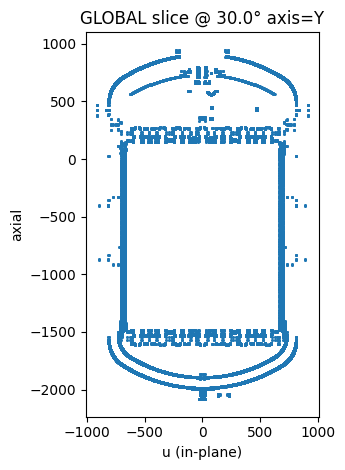

Total leaf subpaths: 6415
Local section edges: 8047
Null/invalid resolves: 0
Local points: 2460521


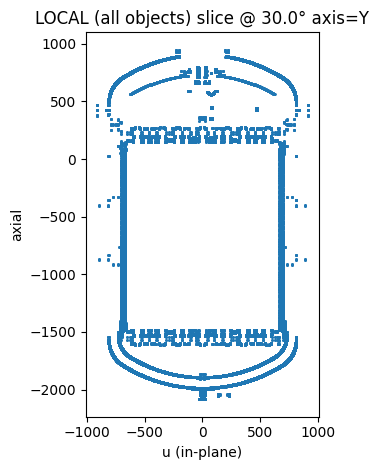

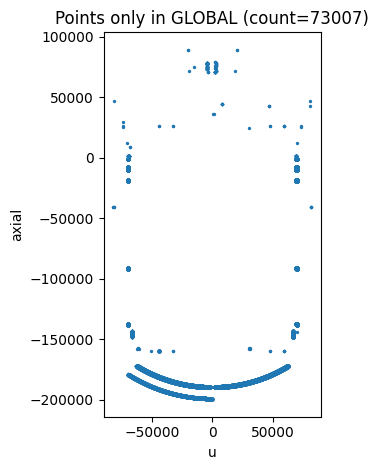

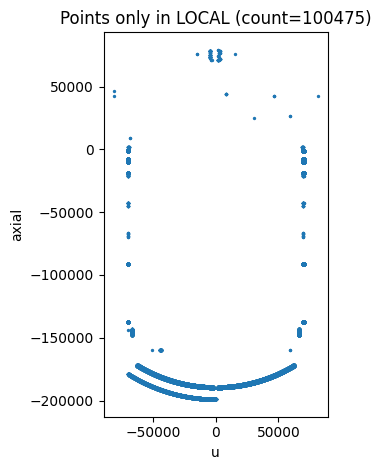

In [30]:
from __future__ import annotations

import csv, math, os
from dataclasses import dataclass
from typing import Any, Dict, List, Tuple, Optional, Set

import FreeCAD  # type: ignore
import Import   # type: ignore
import Part     # type: ignore
import matplotlib.pyplot as plt

Pt2 = Tuple[float, float]


# -------------------- small helpers --------------------

def _safe(obj: Any, attr: str, default: Any = None) -> Any:
    try:
        return getattr(obj, attr)
    except Exception:
        return default

def _truthy_mesh(value: str) -> bool:
    v = (value or "").strip().lower()
    if v in {"1", "true", "yes", "y", "on"}:
        return True
    if v in {"0", "false", "no", "n", "off", ""}:
        return False
    try:
        return int(v) != 0
    except Exception:
        return False

def ensure_path(p: str) -> str:
    p = (p or "").strip()
    return p if p.endswith(".") else (p + ".")

def _bb_to_dict(bb) -> Dict[str, float]:
    return {
        "xmin": float(bb.XMin), "ymin": float(bb.YMin), "zmin": float(bb.ZMin),
        "xmax": float(bb.XMax), "ymax": float(bb.YMax), "zmax": float(bb.ZMax),
    }


# -------------------- csv model + load --------------------

@dataclass(frozen=True)
class ComponentSpec:
    parent: str
    subcomponent: str
    material: str
    mesh: bool
    bc: str
    comment: str

def load_component_csv(csv_path: str) -> Tuple[List[ComponentSpec], Dict[str, List[ComponentSpec]]]:
    specs: List[ComponentSpec] = []
    by_bc_material: Dict[str, List[ComponentSpec]] = {}

    with open(csv_path, "r", encoding="utf-8-sig", newline="") as f:
        reader = csv.DictReader(f)
        required = {"Parent", "Subcomponent", "Material", "Mesh", "BC", "Comment"}
        missing = required - set(reader.fieldnames or [])
        if missing:
            raise ValueError(f"CSV missing required columns: {sorted(missing)}. Found: {reader.fieldnames}")

        for row in reader:
            parent = (row.get("Parent") or "").strip()
            sub = (row.get("Subcomponent") or "").strip()
            material = (row.get("Material") or "").strip() or "NA"
            mesh = _truthy_mesh(row.get("Mesh") or "")
            bc = (row.get("BC") or "").strip() or "NA"
            comment = (row.get("Comment") or "").strip()

            if not parent and not sub:
                continue

            spec = ComponentSpec(parent=parent, subcomponent=sub, material=material, mesh=mesh, bc=bc, comment=comment)
            specs.append(spec)

            key = f"{bc}|{material}"
            by_bc_material.setdefault(key, []).append(spec)

    return specs, by_bc_material

def mesh_targets_from_specs(specs: List[ComponentSpec]) -> List[ComponentSpec]:
    return [s for s in specs if s.mesh]


# -------------------- step load --------------------

def load_step(step_path: str, doc_name: str = "imported_step") -> Any:
    doc = FreeCAD.newDocument(doc_name)
    Import.insert(step_path, doc.Name)
    doc.recompute()
    return doc

def find_step_root(doc: Any) -> Any:
    root = None
    for o in getattr(doc, "Objects", []) or []:
        if not getattr(o, "InList", []):
            root = o
            break
    if root is None:
        raise RuntimeError("Could not determine STEP root object")
    return root


# -------------------- hierarchy indexing --------------------

def get_child_by_name(parent: Any, name: str):
    target = (name or "").strip()
    for ch in getattr(parent, "Group", []) or []:
        if str(getattr(ch, "Name", "") or "").strip() == target:
            return ch
    return None

def get_children_by_label(parent: Any, label: str) -> List[Any]:
    target = (label or "").strip()
    out = []
    for ch in getattr(parent, "Group", []) or []:
        if str(getattr(ch, "Label", "") or "").strip() == target:
            out.append(ch)
    return out

def build_label_object_index(doc: Any) -> Dict[str, List[Any]]:
    """
    Label -> [objects]
    Includes App::Part and leaf objects with non-null Shape.
    """
    idx: Dict[str, List[Any]] = {}
    seen: set[int] = set()

    def add(obj: Any):
        if obj is None:
            return
        oid = id(obj)
        if oid in seen:
            return
        seen.add(oid)

        lab = str(getattr(obj, "Label", "") or "").strip()
        if lab:
            idx.setdefault(lab, []).append(obj)

        try:
            grp = list(getattr(obj, "Group", []))
        except Exception:
            grp = []
        for ch in grp:
            add(ch)

    for o in getattr(doc, "Objects", []) or []:
        type_id = str(getattr(o, "TypeId", "") or "")
        is_part = (type_id == "App::Part")

        has_shape = False
        if not is_part:
            try:
                sh = getattr(o, "Shape", None)
                has_shape = (sh is not None and not sh.isNull())
            except Exception:
                has_shape = False

        if is_part or has_shape:
            add(o)
        else:
            try:
                grp = list(getattr(o, "Group", []))
            except Exception:
                grp = []
            for ch in grp:
                add(ch)

    return idx

def build_object_subpath_index_from_root(root: Any) -> Dict[Any, str]:
    """
    object -> Name-based subpath relative to root:
      "ChildA.ChildB.Leaf."
    """
    idx: Dict[Any, str] = {}
    seen: set[int] = set()

    def children(o: Any) -> List[Any]:
        try:
            return list(getattr(o, "Group", [])) or []
        except Exception:
            return []

    def rec(o: Any, chain_tokens: List[str]):
        oid = id(o)
        if oid in seen:
            return
        seen.add(oid)

        name = str(getattr(o, "Name", "") or "").strip()
        if not name:
            name = str(getattr(o, "Label", "") or "").strip() or "<?>"

        new_chain = chain_tokens + [name]
        idx[o] = ".".join(new_chain) + "."

        for ch in children(o):
            rec(ch, new_chain)

    rec(root, [])
    return idx

def build_hierarchy_index(root_obj: Any) -> Dict[str, Any]:
    """
    Full dict-of-dicts tracing .Group.
    Keys children by Name for stability.
    """
    seen: Set[int] = set()

    def rec(o: Any) -> Dict[str, Any]:
        oid = id(o)
        if oid in seen:
            return {
                "Name": str(_safe(o, "Name", "")),
                "Label": str(_safe(o, "Label", "")),
                "TypeId": str(_safe(o, "TypeId", "")),
                "Children": {},
                "_note": "duplicate_reference_not_expanded",
            }
        seen.add(oid)

        node: Dict[str, Any] = {
            "Name": str(_safe(o, "Name", "")),
            "Label": str(_safe(o, "Label", "")),
            "TypeId": str(_safe(o, "TypeId", "")),
            "Children": {},
        }

        try:
            children = list(getattr(o, "Group", []) or [])
        except Exception:
            children = []

        for ch in children:
            ch_name = str(_safe(ch, "Name", "")) or f"<unnamed_{id(ch)}>"
            node["Children"][ch_name] = rec(ch)

        return node

    return rec(root_obj)


# -------------------- csv -> resolved instance subpaths --------------------

def resolve_targets_from_csv_paths(
    *,
    doc: Any,
    root: Any,
    step_path: str,
    csv_path: str,
    label_index: Dict[str, List[Any]],
    obj2path: Dict[Any, str],
) -> Tuple[List[ComponentSpec], Dict[str, List[str]], List[str], List[ComponentSpec], Dict[str, List[ComponentSpec]]]:
    specs, by_group = load_component_csv(csv_path)
    targets = mesh_targets_from_specs(specs)

    resolved: Dict[str, List[str]] = {}
    unresolved: List[str] = []

    def objs_for_label(sub: str) -> List[Any]:
        if sub in label_index:
            return list(label_index[sub])
        if sub.endswith("***"):
            prefix = sub[:-3]
            out: List[Any] = []
            for lab, lst in label_index.items():
                if lab.startswith(prefix):
                    out.extend(lst)
            return out
        return []

    for t in targets:
        sub = (t.subcomponent or "").strip()
        objs = objs_for_label(sub) if sub else []
        paths: List[str] = []
        for o in objs:
            p = obj2path.get(o)
            if p:
                paths.append(p)

        seenp: set[str] = set()
        paths_unique: List[str] = []
        for p in paths:
            if p not in seenp:
                seenp.add(p)
                paths_unique.append(p)

        resolved[sub] = paths_unique
        if not paths_unique:
            unresolved.append(sub)

    print(f"STEP: {os.path.abspath(step_path)}")
    print(f"CSV:  {os.path.abspath(csv_path)}")
    print(f"Mesh targets (CSV): {len(targets)}")
    print(f"Resolved targets:   {sum(1 for k in resolved if resolved[k])} labels")
    print(f"Unresolved targets: {len(unresolved)} labels")

    return targets, resolved, unresolved, specs, by_group

def flatten_resolved_instances(resolved: Dict[str, List[str]]) -> List[Dict[str, str]]:
    instances: List[Dict[str, str]] = []
    for label, paths in resolved.items():
        for sp in (paths or []):
            instances.append({"label": label, "subpath": ensure_path(sp)})
    instances.sort(key=lambda d: (d["label"], d["subpath"]))
    return instances


# -------------------- transform probing --------------------

def _matrix_apply_to_point(m: FreeCAD.Matrix, v: FreeCAD.Vector) -> FreeCAD.Vector:
    mul = getattr(m, "multiply", None)
    if callable(mul):
        return mul(v)
    raise RuntimeError("FreeCAD.Matrix.multiply(Vector) not available in this build")

def _basis_reference_from_matrix(m: FreeCAD.Matrix) -> Dict[str, Tuple[float, float, float]]:
    o  = _matrix_apply_to_point(m, FreeCAD.Vector(0, 0, 0))
    ex = _matrix_apply_to_point(m, FreeCAD.Vector(1, 0, 0))
    ey = _matrix_apply_to_point(m, FreeCAD.Vector(0, 1, 0))
    ez = _matrix_apply_to_point(m, FreeCAD.Vector(0, 0, 1))
    return {
        "origin_xyz": (float(o.x),  float(o.y),  float(o.z)),
        "ex_xyz":     (float(ex.x), float(ex.y), float(ex.z)),
        "ey_xyz":     (float(ey.x), float(ey.y), float(ey.z)),
        "ez_xyz":     (float(ez.x), float(ez.y), float(ez.z)),
    }

def _placement_reference(pl: Any) -> Dict[str, Any]:
    out: Dict[str, Any] = {"placement": None, "matrix": None, "basis": None}
    if pl is None:
        return out
    out["placement"] = str(pl)
    if hasattr(pl, "toMatrix"):
        try:
            m = pl.toMatrix()
            out["matrix"] = m
            out["basis"] = _basis_reference_from_matrix(m)
        except Exception as e:
            out["matrix_error"] = repr(e)
    return out

def evaluate_instance_transforms(root: Any, subpath: str) -> Dict[str, Any]:
    sp = ensure_path(subpath)
    results: Dict[str, Any] = {"subpath": sp}

    # (1) getSubObject(matrix=..., transform=True)
    mat = FreeCAD.Matrix()
    obj = None
    try:
        obj = root.getSubObject(sp, matrix=mat, transform=True)
        results["getSubObject"] = {
            "obj_type": type(obj).__name__ if obj is not None else None,
            "obj_typeid": str(_safe(obj, "TypeId", "")) if obj is not None else "",
            "obj_name": str(_safe(obj, "Name", "")) if obj is not None else "",
            "obj_label": str(_safe(obj, "Label", "")) if obj is not None else "",
        }
        results["getSubObject_matrix"] = mat
        results["getSubObject_basis"] = _basis_reference_from_matrix(mat)
    except Exception as e:
        results["getSubObject_error"] = repr(e)

    # (2) getSubObject(retType=3)
    try:
        pl3 = root.getSubObject(sp, retType=3)
        results["retType3"] = _placement_reference(pl3)
    except Exception as e:
        results["retType3_error"] = repr(e)

    # (3) object-local placement (not instance-aware, but capture)
    if obj is not None:
        try:
            if hasattr(obj, "Placement"):
                results["obj_Placement"] = _placement_reference(obj.Placement)
        except Exception as e:
            results["obj_Placement_error"] = repr(e)

        for meth_name in ("getGlobalPlacement", "globalPlacement", "getGlobalTransform"):
            meth = getattr(obj, meth_name, None)
            if callable(meth):
                try:
                    gp = meth()
                    results[meth_name] = _placement_reference(gp)
                except Exception as e:
                    results[meth_name + "_error"] = repr(e)

        # (4) if App::Link: getLinkedObject(recurse=True,...)
        typeid = str(_safe(obj, "TypeId", ""))
        if "App::Link" in typeid or typeid == "App::Link":
            link_mat = FreeCAD.Matrix()
            try:
                base = obj.getLinkedObject(recurse=True, mat=link_mat, transform=True)
                results["getLinkedObject"] = {
                    "base_type": type(base).__name__ if base is not None else None,
                    "base_typeid": str(_safe(base, "TypeId", "")) if base is not None else "",
                    "base_name": str(_safe(base, "Name", "")) if base is not None else "",
                    "base_label": str(_safe(base, "Label", "")) if base is not None else "",
                    "link_LinkTransform": _safe(obj, "LinkTransform", None),
                    "link_LinkPlacement": str(_safe(obj, "LinkPlacement", None)),
                }
                results["getLinkedObject_matrix"] = link_mat
                results["getLinkedObject_basis"] = _basis_reference_from_matrix(link_mat)
            except Exception as e:
                results["getLinkedObject_error"] = repr(e)

        # (5) bbox sanity check
        try:
            sh = getattr(obj, "Shape", None)
            if sh is not None and hasattr(sh, "BoundBox") and not sh.isNull():
                results["shape_bbox_local"] = _bb_to_dict(sh.BoundBox)
        except Exception as e:
            results["shape_bbox_local_error"] = repr(e)

    return results


# -------------------- slicing + projection primitives --------------------

def _make_vertical_plane_face(*, angle_deg: float, origin=(0.0, 0.0, 0.0), axis: str = "Y") -> Part.Shape:
    ox, oy, oz = origin
    a = math.radians(float(angle_deg))
    ax = axis.upper().strip()

    if ax == "Y":
        nx, ny, nz = math.sin(a), 0.0, -math.cos(a)
    elif ax == "Z":
        nx, ny, nz = -math.sin(a), math.cos(a), 0.0
    elif ax == "X":
        nx, ny, nz = 0.0, -math.sin(a), math.cos(a)
    else:
        raise ValueError(f"axis must be 'X','Y','Z' (got {axis!r})")

    return Part.Plane(FreeCAD.Vector(ox, oy, oz), FreeCAD.Vector(nx, ny, nz)).toShape()

def _v3_to_2d_in_vertical_plane(v: FreeCAD.Vector, angle_deg: float, axis: str = "Y") -> Pt2:
    a = math.radians(float(angle_deg))
    ax = axis.upper().strip()

    if ax == "X":
        A  = (1.0, 0.0, 0.0)
        e1 = (0.0, 1.0, 0.0)
        e2 = (0.0, 0.0, 1.0)
    elif ax == "Y":
        A  = (0.0, 1.0, 0.0)
        e1 = (1.0, 0.0, 0.0)
        e2 = (0.0, 0.0, 1.0)
    elif ax == "Z":
        A  = (0.0, 0.0, 1.0)
        e1 = (1.0, 0.0, 0.0)
        e2 = (0.0, 1.0, 0.0)
    else:
        raise ValueError(f"axis must be 'X','Y','Z' (got {axis!r})")

    rx = math.cos(a) * e1[0] + math.sin(a) * e2[0]
    ry = math.cos(a) * e1[1] + math.sin(a) * e2[1]
    rz = math.cos(a) * e1[2] + math.sin(a) * e2[2]

    vx, vy, vz = float(v.x), float(v.y), float(v.z)
    axial = vx * A[0] + vy * A[1] + vz * A[2]
    u = vx * rx + vy * ry + vz * rz
    return (float(u), float(axial))

def _section_edges_from_shape(
    sh: Any,
    plane_face: Any,
    *,
    tol: float = 1e-7,
) -> List[Any]:
    if sh is None or not hasattr(sh, "isNull") or sh.isNull():
        return []
    try:
        sec = sh.section(plane_face)
    except Exception:
        return []
    if sec is None or sec.isNull():
        return []
    try:
        sec = sec.removeSplitter()
    except Exception:
        pass
    try:
        sec = sec.cleanTolerance(float(tol))
    except Exception:
        pass
    try:
        return list(sec.Edges) or []
    except Exception:
        return []

def sample_edge_points_2d(
    edges: List[Any],
    *,
    angle_deg: float,
    axis: str = "Y",
    deflection: float = 2.0,
    number: Optional[int] = None,
) -> List[Pt2]:
    pts2d: List[Pt2] = []
    for e in edges:
        try:
            if number is not None:
                verts = e.discretize(Number=int(number))
            else:
                verts = e.discretize(Deflection=float(deflection))
        except Exception:
            continue
        for v in verts:
            pts2d.append(_v3_to_2d_in_vertical_plane(v, angle_deg=float(angle_deg), axis=axis))
    return pts2d


# -------------------- method 1: global slice --------------------

def slice_global_and_plot(
    *,
    root: Any,
    angle_deg: float,
    axis: str = "Y",
    origin=(0.0, 0.0, 0.0),
    tol: float = 1e-7,
    deflection: float = 2.0,
    number: Optional[int] = None,
    point_size: float = 1.0,
) -> List[Pt2]:
    plane_face = _make_vertical_plane_face(angle_deg=float(angle_deg), origin=origin, axis=axis)

    sh = getattr(root, "Shape", None)
    if sh is None or sh.isNull():
        return []

    edges = _section_edges_from_shape(sh, plane_face, tol=tol)
    pts2d = sample_edge_points_2d(edges, angle_deg=float(angle_deg), axis=axis, deflection=deflection, number=number)

    print("Global edges:", len(edges))
    print("Global points:", len(pts2d))

    if pts2d:
        xs = [p[0] for p in pts2d]
        ys = [p[1] for p in pts2d]
        plt.figure()
        plt.scatter(xs, ys, s=point_size)
        plt.gca().set_aspect("equal", adjustable="box")
        plt.title(f"GLOBAL slice @ {float(angle_deg):.1f}° axis={axis}")
        plt.xlabel("u (in-plane)")
        plt.ylabel("axial")
        plt.tight_layout()
        plt.show()

    return pts2d


# -------------------- method 2: local (subpaths) slice --------------------

def collect_leaf_geometry_subpaths(root: Any) -> List[str]:
    """
    Name-based subpaths relative to root for nodes that carry geometry.
    Rule:
      - If node is App::Part: descend, do not include container itself.
      - Else: include leaf nodes with non-null Shape.
    """
    out: List[str] = []
    seen: Set[int] = set()

    def has_nonnull_shape(o: Any) -> bool:
        try:
            sh = getattr(o, "Shape", None)
            return sh is not None and hasattr(sh, "isNull") and not sh.isNull()
        except Exception:
            return False

    def rec(parent: Any, toks: List[str]):
        try:
            children = list(getattr(parent, "Group", []) or [])
        except Exception:
            children = []

        if not children:
            # leaf
            if parent is not root and has_nonnull_shape(parent):
                name = str(getattr(parent, "Name", "") or "")
                if name:
                    out.append(".".join(toks + [name]) + ".")
            return

        for ch in children:
            oid = id(ch)
            if oid in seen:
                continue
            seen.add(oid)

            name = str(getattr(ch, "Name", "") or "")
            if not name:
                continue

            typeid = str(getattr(ch, "TypeId", "") or "")
            if typeid == "App::Part":
                rec(ch, toks + [name])
            else:
                rec(ch, toks + [name])

    rec(root, [])
    return out

def slice_local_all_objects_and_plot(
    *,
    root: Any,
    angle_deg: float,
    axis: str = "Y",
    origin=(0.0, 0.0, 0.0),
    tol: float = 1e-7,
    deflection: float = 2.0,
    number: Optional[int] = None,
    point_size: float = 1.0,
) -> List[Pt2]:
    plane_face = _make_vertical_plane_face(angle_deg=float(angle_deg), origin=origin, axis=axis)

    subpaths = collect_leaf_geometry_subpaths(root)
    print("Total leaf subpaths:", len(subpaths))

    all_pts2d: List[Pt2] = []
    total_edges = 0
    null_resolves = 0

    for sp in subpaths:
        sp = ensure_path(sp)
        try:
            sh = root.getSubObject(sp)
        except Exception:
            sh = None

        if sh is None or not hasattr(sh, "isNull") or sh.isNull():
            null_resolves += 1
            continue

        edges = _section_edges_from_shape(sh, plane_face, tol=tol)
        if not edges:
            continue

        total_edges += len(edges)
        all_pts2d.extend(sample_edge_points_2d(edges, angle_deg=float(angle_deg), axis=axis, deflection=deflection, number=number))

    print("Local section edges:", total_edges)
    print("Null/invalid resolves:", null_resolves)
    print("Local points:", len(all_pts2d))

    if all_pts2d:
        xs = [p[0] for p in all_pts2d]
        ys = [p[1] for p in all_pts2d]
        plt.figure()
        plt.scatter(xs, ys, s=point_size)
        plt.gca().set_aspect("equal", adjustable="box")
        plt.title(f"LOCAL (all objects) slice @ {float(angle_deg):.1f}° axis={axis}")
        plt.xlabel("u (in-plane)")
        plt.ylabel("axial")
        plt.tight_layout()
        plt.show()

    return all_pts2d


# -------------------- comparison utilities --------------------

def normalize_pts(pts: List[Pt2], tol: float = 1e-6) -> Set[Tuple[int, int]]:
    norm: Set[Tuple[int, int]] = set()
    t = float(tol)
    for x, y in pts:
        norm.add((round(float(x) / t), round(float(y) / t)))
    return norm

def compare_point_sets(global_pts: List[Pt2], local_pts: List[Pt2], tol: float = 1e-6):
    G = normalize_pts(global_pts, tol=tol)
    L = normalize_pts(local_pts, tol=tol)

    only_global = G - L
    only_local  = L - G
    intersection = G & L

    result = {
        "global_count": len(G),
        "local_count": len(L),
        "intersection": len(intersection),
        "only_global": len(only_global),
        "only_local": len(only_local),
        "global_complete_in_local": len(only_global) == 0,
        "local_complete_in_global": len(only_local) == 0,
    }
    return result, only_global, only_local

def denormalize(keys: Set[Tuple[int, int]], tol: float = 1e-6) -> List[Pt2]:
    t = float(tol)
    return [(kx * t, ky * t) for (kx, ky) in keys]

def plot_unshared_points(only_global_keys: Set[Tuple[int, int]], only_local_keys: Set[Tuple[int, int]], tol: float = 1e-6, point_size: float = 2.0):
    only_global_xy = denormalize(only_global_keys, tol=tol)
    only_local_xy  = denormalize(only_local_keys,  tol=tol)

    plt.figure()
    if only_global_xy:
        xs = [p[0] for p in only_global_xy]
        ys = [p[1] for p in only_global_xy]
        plt.scatter(xs, ys, s=point_size)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.title(f"Points only in GLOBAL (count={len(only_global_xy)})")
    plt.xlabel("u")
    plt.ylabel("axial")
    plt.tight_layout()
    plt.show()

    plt.figure()
    if only_local_xy:
        xs = [p[0] for p in only_local_xy]
        ys = [p[1] for p in only_local_xy]
        plt.scatter(xs, ys, s=point_size)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.title(f"Points only in LOCAL (count={len(only_local_xy)})")
    plt.xlabel("u")
    plt.ylabel("axial")
    plt.tight_layout()
    plt.show()


# -------------------- minimal "setup" cell usage --------------------
STEP_PATH = "./geometry/createGeometryFromCAD/XENT-TPC_20250428.STEP"
CSV_PATH  = "./geometry/createGeometryFromCAD/naming_convention.csv" 
doc = load_step(STEP_PATH, doc_name="nb_step")
root = find_step_root(doc)
# optional: CSV resolution (not used by slicing, but kept for later)
label_index = build_label_object_index(doc)
obj2path = build_object_subpath_index_from_root(root)
targets, resolved, unresolved, specs, by_group = resolve_targets_from_csv_paths(
    doc=doc, root=root, step_path=STEP_PATH, csv_path=CSV_PATH, label_index=label_index, obj2path=obj2path
)
instances = flatten_resolved_instances(resolved)
# METHOD 1: global slice
pts2d = slice_global_and_plot(root=root, angle_deg=30.0, axis="Y", origin=(0,0,0), tol=1e-12, deflection=1e-6)
# METHOD 2: local slice
pts2d_all = slice_local_all_objects_and_plot(root=root, angle_deg=30.0, axis="Y", origin=(0,0,0), tol=1e-12, deflection=1e-6)
# compare
comp, only_g, only_l = compare_point_sets(pts2d, pts2d_all, tol=1e-8)
plot_unshared_points(only_g, only_l, tol=1e-6)

# Actual Generation of the pts list

In [39]:
from __future__ import annotations

import math, traceback
from dataclasses import dataclass
from typing import Any, Dict, List, Optional, Tuple, Union

import FreeCAD  # type: ignore
import Part     # type: ignore

Pt2 = Tuple[float, float]
Instr = Union[List[float], List[object]]  # [x,y] or ["line",x,y] or ["arc",x,y,cx,cy,cw] etc.

# -------------------- Data model (same intent as your script) --------------------

@dataclass(frozen=True)
class ComponentSpec:
    parent: str
    subcomponent: str
    material: str
    mesh: bool
    bc: str
    comment: str

# -------------------- Small helpers --------------------

def _safe(obj: Any, attr: str, default: Any = None) -> Any:
    try:
        return getattr(obj, attr)
    except Exception:
        return default

def ensure_path(p: str) -> str:
    p = (p or "").strip()
    return p if p.endswith(".") else p + "."

def _build_spec_index(targets: List[ComponentSpec]) -> Dict[str, ComponentSpec]:
    return {t.subcomponent: t for t in targets}

# -------------------- Shape resolution (instance-aware) --------------------
# This matches the approach in your script: root.getSubObject(path) + retType=3 placement apply. :contentReference[oaicite:1]{index=1}

def _is_toposhape(x: Any) -> bool:
    return (
        x is not None
        and hasattr(x, "isNull") and callable(getattr(x, "isNull", None))
        and hasattr(x, "section") and callable(getattr(x, "section", None))
        and hasattr(x, "BoundBox")
    )

def ensure_path(p: str) -> str:
    p = (p or "").strip()
    return p if p.endswith(".") else p + "."

def normalize_subpath_relative_to_root(root: Any, subpath: str) -> str:
    """
    Make sure subpath is compatible with root.getSubObject(...):
      - always trailing dot
      - remove leading "<root.Name>." if present
      - (optionally) also remove leading "<root.Label>." if your builder used labels
    """
    sp = ensure_path(subpath)

    root_name = str(_safe(root, "Name", "") or "").strip()
    root_label = str(_safe(root, "Label", "") or "").strip()

    if root_name and sp.startswith(root_name + "."):
        sp = sp[len(root_name) + 1 :]

    # optional: if you ever built paths from labels (usually you didn't for getSubObject)
    if root_label and sp.startswith(root_label + "."):
        sp = sp[len(root_label) + 1 :]

    return ensure_path(sp)
def resolve_shape_via_root_subpath(
    root: Any,
    subpath: str,
) -> Tuple[Part.TopoShape, Optional[FreeCAD.Matrix]]:
    """
    Resolve a TopoShape from a Name‑based subpath relative to root,
    apply the accumulated placement, and return (shape, placement_matrix).

    - shape: the TopoShape, **transformed to global coordinates** if possible.
    - placement_matrix: a FreeCAD.Matrix that must be applied to **curve geometry**
      (poles, arc centres) if and only if the shape was **not** fully transformed.
      If the shape was transformed via `transformGeometry`, this matrix is None.

    Raises RuntimeError on failure.
    """
    sp = normalize_subpath_relative_to_root(root, subpath)

    # ---- 1. Get the object at this subpath ----
    sub = root.getSubObject(sp)
    if sub is None:
        raise RuntimeError(f"getSubObject returned None for subpath={sp!r} (from {subpath!r})")

    # ---- 2. Extract a TopoShape from whatever we got ----
    sh = None
    if _is_toposhape(sub) and not sub.isNull():
        sh = sub
    elif hasattr(sub, "Shape"):
        try:
            cand = sub.Shape
        except Exception:
            cand = None
        if _is_toposhape(cand) and not cand.isNull():
            sh = cand
    if sh is None:
        to_shape = getattr(sub, "toShape", None)
        if callable(to_shape):
            try:
                cand = sub.toShape()
            except Exception:
                cand = None
            if _is_toposhape(cand) and not cand.isNull():
                sh = cand

    if sh is None:
        raise RuntimeError(
            f"Could not obtain TopoShape for subpath={sp!r} (type={type(sub).__name__})"
        )

    # ---- 3. Get the accumulated placement (if any) ----
    pl = None
    try:
        pl = root.getSubObject(sp, retType=3)
    except Exception:
        pl = None

    # If there is no placement, return shape as-is and no matrix.
    if pl is None:
        return sh, None

    # ---- 4. Safely convert Placement to Matrix (handle pre‑0.20.2 bug) ----
    def placement_to_matrix_safe(pl: FreeCAD.Placement) -> FreeCAD.Matrix:
        """Workaround for the toMatrix() bug fixed in April 2022."""
        # Check FreeCAD version
        ver = FreeCAD.Version()
        if ver[0] == "0" and int(ver[1]) <= 19 and (int(ver[2]) < 2 if len(ver) > 2 else True):
            # Manual conversion for older versions
            m = FreeCAD.Matrix()
            m.translate(pl.Base)
            q = pl.Rotation.Q
            m.rotate(q)   # rotation via quaternion is safe
            return m
        else:
            # Modern FreeCAD – toMatrix() is reliable
            return pl.toMatrix()

    m = placement_to_matrix_safe(pl)

    # ---- 5. Try to bake the transformation into the shape (preferred) ----
    try:
        sh2 = sh.copy()
        sh2 = sh2.transformGeometry(m)   # modifies the actual geometry
        # Success – shape is now in global coordinates, no extra matrix needed.
        return sh2, None
    except Exception:
        # transformGeometry failed – fall back to transformShape.
        # This leaves the curve geometry untouched, so we must return the matrix.
        sh2 = sh.copy()
        sh2.transformShape(m)           # only changes placement, not curves
        return sh2, m

def resolve_shape_or_collective(root: Any, subpath: str) -> Dict[str, Any]:
    """
    Returns:
      {"status": "shape", "shape": TopoShape, "sp": normalized_path}
      {"status": "collective", "sp": normalized_path, "type": "..."}   # App::Part etc.
      {"status": "missing", "sp": normalized_path}
      {"status": "error", "sp": normalized_path, "error": "..."}
    """
    sp = normalize_subpath_relative_to_root(root, subpath)

    try:
        sub = root.getSubObject(sp)
    except Exception as e:
        return {"status": "error", "sp": sp, "error": repr(e)}

    if sub is None:
        return {"status": "missing", "sp": sp}

    # If we already got a TopoShape: good
    if _is_toposhape(sub) and not sub.isNull():
        sh = sub
    else:
        sh = None
        # Object with Shape
        if hasattr(sub, "Shape"):
            try:
                cand = sub.Shape
            except Exception:
                cand = None
            if _is_toposhape(cand) and cand is not None and not cand.isNull():
                sh = cand
        # Subshape with toShape()
        if sh is None:
            to_shape = getattr(sub, "toShape", None)
            if callable(to_shape):
                try:
                    cand = sub.toShape()
                except Exception:
                    cand = None
                if _is_toposhape(cand) and cand is not None and not cand.isNull():
                    sh = cand

    if sh is None:
        # This is your “collective” case (often App::Part)
        return {
            "status": "collective",
            "sp": sp,
            "type": type(sub).__name__,
            "TypeId": str(_safe(sub, "TypeId", "")),
            "Name": str(_safe(sub, "Name", "")),
            "Label": str(_safe(sub, "Label", "")),
        }

    # Apply accumulated placement if available
    try:
        pl = root.getSubObject(sp, retType=3)
    except Exception:
        pl = None

    if pl is not None and hasattr(pl, "toMatrix"):
        try:
            m = pl.toMatrix()
            sh2 = sh.copy()
            try:
                sh2 = sh2.transformGeometry(m)
            except Exception:
                sh2.transformShape(m)
            sh = sh2
        except Exception:
            pass

    return {"status": "shape", "shape": sh, "sp": sp}

# ----------------- Drop into Parts ----------------
def _has_valid_shape(o: Any) -> bool:
    try:
        sh = getattr(o, "Shape", None)
        return sh is not None and hasattr(sh, "isNull") and not sh.isNull()
    except Exception:
        return False

def _is_container(o: Any) -> bool:
    return str(_safe(o, "TypeId", "")) == "App::Part"

def expand_to_leaf_geometry_paths(root: Any, subpath: str) -> List[str]:
    """
    Given a Name-based subpath relative to root, return a list of Name-based subpaths
    (relative to root) that point to leaf geometry objects (non-null Shape).

    If subpath already points to a leaf geometry object, returns [subpath].
    If it points to a container, returns all descendant leaf geometry paths.
    """
    sp = normalize_subpath_relative_to_root(root, subpath)

    # Resolve the object at this path (not the shape)
    try:
        obj = root.getSubObject(sp, retType=1)  # object/feature in most FC builds
    except Exception:
        obj = None

    # If retType=1 not supported or returned None, fall back to direct Group walk:
    # We can still walk by splitting tokens and using Group children by Name.
    if obj is None:
        toks = [t for t in sp.split(".") if t]
        cur = root
        for t in toks:
            nxt = None
            for ch in getattr(cur, "Group", []) or []:
                if str(getattr(ch, "Name", "")) == t:
                    nxt = ch
                    break
            cur = nxt
            if cur is None:
                return []
        obj = cur

    if obj is None:
        return []

    # If leaf geometry, keep it
    if _has_valid_shape(obj) and not _is_container(obj):
        return [ensure_path(sp)]

    # If container (or non-leaf with children), collect descendant leaf geometry paths
    out: List[str] = []
    seen: set[int] = set()

    def rec(o: Any, name_tokens: List[str]):
        oid = id(o)
        if oid in seen:
            return
        seen.add(oid)

        children = list(getattr(o, "Group", []) or [])
        if not children:
            # leaf: include if it has geometry
            if _has_valid_shape(o) and not _is_container(o):
                out.append(".".join(name_tokens) + ".")
            return

        for ch in children:
            nm = str(getattr(ch, "Name", "") or "")
            if not nm:
                continue
            rec(ch, name_tokens + [nm])

    toks = [t for t in sp.split(".") if t]
    rec(obj, toks)
    return out



# -------------------- Slicing --------------------

def slice_paths_with_vertical_plane(
    root: Any,
    subpath: str,
    angle_deg: float,
    origin: Tuple[float, float, float] = (0.0, 0.0, 0.0),
    axis: str = "Y",
    tol: float = 1e-7,
) -> Tuple[List[Part.Edge], Optional[FreeCAD.Matrix]]:
    """
    Slice a single resolved subpath with a vertical plane.

    Returns:
        edges : list of edges from the section.
        matrix: placement matrix to apply to curve geometry (or None if already baked).
    """
    shape, matrix = resolve_shape_via_root_subpath(root, subpath)
    if shape is None or shape.isNull():
        return [], matrix

    # Build the vertical plane
    ox, oy, oz = origin
    a = math.radians(float(angle_deg))
    ax = axis.upper().strip()
    if ax == "Y":
        nx, ny, nz = math.sin(a), 0.0, -math.cos(a)
    elif ax == "Z":
        nx, ny, nz = -math.sin(a), math.cos(a), 0.0
    elif ax == "X":
        nx, ny, nz = 0.0, -math.sin(a), math.cos(a)
    else:
        raise ValueError(f"axis must be 'X','Y','Z' (got {axis!r})")

    plane_face = Part.Plane(
        FreeCAD.Vector(ox, oy, oz),
        FreeCAD.Vector(nx, ny, nz)
    ).toShape()

    try:
        sec = shape.section(plane_face)
    except Exception:
        return [], matrix
    if sec is None or sec.isNull():
        return [], matrix

    try:
        sec = sec.removeSplitter()
    except Exception:
        pass
    try:
        sec = sec.cleanTolerance(float(tol))
    except Exception:
        pass

    edges: List[Part.Edge] = []
    try:
        edges = list(sec.Edges)
    except Exception:
        pass

    return edges, matrix
# -------------------- Projection + serialization (the “pts_lists” format) --------------------
# These mirror your script’s chain/ordering/transcription logic. :contentReference[oaicite:2]{index=2}

def _v3_to_2d_in_vertical_plane(v: FreeCAD.Vector, angle_deg: float, axis: str = "Y") -> Pt2:
    a = math.radians(float(angle_deg))
    ax = axis.upper().strip()

    if ax == "X":
        A  = (1.0, 0.0, 0.0); e1 = (0.0, 1.0, 0.0); e2 = (0.0, 0.0, 1.0)
    elif ax == "Y":
        A  = (0.0, 1.0, 0.0); e1 = (1.0, 0.0, 0.0); e2 = (0.0, 0.0, 1.0)
    elif ax == "Z":
        A  = (0.0, 0.0, 1.0); e1 = (1.0, 0.0, 0.0); e2 = (0.0, 1.0, 0.0)
    else:
        raise ValueError(f"axis must be 'X','Y','Z' (got {axis!r})")

    rx = math.cos(a) * e1[0] + math.sin(a) * e2[0]
    ry = math.cos(a) * e1[1] + math.sin(a) * e2[1]
    rz = math.cos(a) * e1[2] + math.sin(a) * e2[2]

    vx, vy, vz = float(v.x), float(v.y), float(v.z)
    axial = vx * A[0] + vy * A[1] + vz * A[2]
    u = vx * rx + vy * ry + vz * rz
    return (float(u), float(axial))

def _pt_key(p: Pt2, tol: float) -> Tuple[int, int]:
    return (int(round(p[0] / tol)), int(round(p[1] / tol)))

def _close_enough(p: Pt2, q: Pt2, tol: float) -> bool:
    return (p[0]-q[0])**2 + (p[1]-q[1])**2 <= tol*tol

def sort_edges_into_wires(edges: List[Part.Edge]) -> List[List[Part.Edge]]:
    if not edges:
        return []
    groups = Part.sortEdges(edges)
    return [list(g) for g in groups if g]

def _edge_endpoints_2d_oriented(e: Part.Edge, fwd: bool, angle_deg: float, axis: str = "Y") -> Tuple[Pt2, Pt2]:
    u0, u1 = e.ParameterRange
    pA3 = e.valueAt(u0 if fwd else u1)
    pB3 = e.valueAt(u1 if fwd else u0)
    return (
        _v3_to_2d_in_vertical_plane(pA3, angle_deg, axis=axis),
        _v3_to_2d_in_vertical_plane(pB3, angle_deg, axis=axis),
    )

def _circle_center_2d(e: Part.Edge, angle_deg: float, axis: str = "Y") -> Pt2:
    """Return the centre of a circular edge in the 2D projection plane.
    Uses CenterOfCurvature, which respects the shape's placement."""
    # For a circular edge, the centre of curvature is constant.
    center_3d = e.CenterOfCurvature(e.FirstParameter)
    return _v3_to_2d_in_vertical_plane(center_3d, angle_deg, axis=axis)

def _arc_cw_flag(p0: Pt2, p1: Pt2, c: Pt2) -> bool:
    ax, ay = p0[0] - c[0], p0[1] - c[1]
    bx, by = p1[0] - c[0], p1[1] - c[1]
    return (ax * by - ay * bx) < 0.0

def wire_to_pts_instructions_strict(
    ordered_edges: List[Tuple[Part.Edge, bool]],
    angle_deg: float,
    axis: str = "Y",
    placement: Optional[FreeCAD.Placement] = None,
) -> List[Instr]:
    """
    Convert a topologically ordered list of edges (with orientation flags)
    into a sequence of drawing instructions.

    If `placement` is given, it is applied to the **geometry** of BSpline curves
    (poles). For arcs, the centre is already correct via CenterOfCurvature.
    """
    if not ordered_edges:
        return []

    # Pre‑compute transformation matrix from placement (if provided)
    mat = None
    if placement is not None:
        if hasattr(placement, "toMatrix"):
            mat = placement.toMatrix()
        else:
            mat = placement  # caller already passed a matrix

    pts: List[Instr] = []

    # First edge's start point
    e0, fwd0 = ordered_edges[0]
    p0_3 = e0.valueAt(e0.FirstParameter if fwd0 else e0.LastParameter)
    current = _v3_to_2d_in_vertical_plane(p0_3, angle_deg, axis=axis)

    for e, fwd in ordered_edges:
        pA, pB = _edge_endpoints_2d_oriented(e, fwd, angle_deg, axis=axis)

        curve = e.Curve

        if isinstance(curve, Part.Line):
            pts.append(["line", pA[0], pA[1]])

        elif isinstance(curve, Part.Circle):
            if curve.isClosed():
                raise ValueError("Full circle edge cannot be represented as a single arc.")
            center = _circle_center_2d(e, angle_deg, axis=axis)
            cw = _arc_cw_flag(pA, pB, center)
            pts.append(["arc", pA[0], pA[1], center[0], center[1], cw])

        elif isinstance(curve, Part.BSplineCurve):
            # Poles are in local curve coordinates – transform them
            poles_3d = list(curve.getPoles())
            if mat is not None:
                poles_3d = [mat.multiply(p) for p in poles_3d]
            poles_2d = [_v3_to_2d_in_vertical_plane(p, angle_deg, axis) for p in poles_3d]

            weights = list(curve.getWeights()) if curve.isRational() else []
            knots = list(curve.getKnots())
            mults = list(curve.getMultiplicities())
            degree = curve.Degree
            periodic = curve.isPeriodic()

            payload = {
                "poles": poles_2d,
                "weights": weights,
                "knots": knots,
                "multiplicities": mults,
                "degree": degree,
                "periodic": periodic,
            }
            pts.append(["bspline", pA[0], pA[1], payload])

        else:
            raise TypeError(f"Unsupported curve type: {type(curve).__name__}")

        current = pB

    return pts

def edges_to_pts_chains_strict(
    edges: List[Part.Edge],
    angle_deg: float,
    axis: str = "Y",
    deflection: float = 1e-6,
    placement: Optional[FreeCAD.Placement] = None,
) -> Tuple[List[List[Pt2]], List, Optional[Dict[str, Any]]]:
    """
    Convert section edges into ordered point chains.

    - Edges are grouped into topologically connected wires via Part.sortEdges().
    - Each edge is discretised with the given deflection.
    - Points are projected to 2D.
    - Returns (list_of_point_chains, [], None) – compatible with your existing pipeline.

    The `placement` argument is **only used** if you later call
    wire_to_pts_instructions_strict; here we ignore it because we discretise directly.
    """
    if not edges:
        return [], [], None

    try:
        wire_groups = Part.sortEdges(edges)
        all_chains: List[List[Pt2]] = []

        for group in wire_groups:
            wire = Part.Wire(group)  # for topological orientation
            chain_pts: List[Pt2] = []

            for i, e in enumerate(group):
                # Determine correct orientation relative to the wire
                if i == 0:
                    fwd = True
                else:
                    prev_e = group[i-1]
                    prev_end = prev_e.valueAt(prev_e.LastParameter)
                    this_start = e.valueAt(e.FirstParameter)
                    this_end = e.valueAt(e.LastParameter)
                    if prev_end.distanceToPoint(this_start) < 1e-7:
                        fwd = True
                    elif prev_end.distanceToPoint(this_end) < 1e-7:
                        fwd = False
                    else:
                        fwd = True  # fallback

                # Discretise edge (3D points)
                verts = e.discretize(Deflection=deflection)
                pts_2d = [_v3_to_2d_in_vertical_plane(v, angle_deg, axis) for v in verts]

                if not fwd:
                    pts_2d.reverse()

                # Avoid duplicate point at the shared vertex
                if chain_pts and pts_2d and _close_enough(chain_pts[-1], pts_2d[0], 1e-7):
                    pts_2d = pts_2d[1:]

                chain_pts.extend(pts_2d)

            all_chains.append(chain_pts)

        return all_chains, [], None

    except Exception as ex:
        print(f"edges_to_pts_chains_strict failed: {ex}")
        return [], [], {
            "type": type(ex).__name__,
            "message": str(ex),
            "traceback": traceback.format_exc(limit=10),
        }

def edges_to_pts_chains_strict(
    edges: List[Part.Edge],
    angle_deg: float,
    axis: str = "Y",
    deflection: float = 1e-6,      # same as your global slice
) -> Tuple[List[List[Pt2]], List, None]:
    """
    Convert section edges directly into ordered point chains.
    No instructions, no tolerance‑based adjacency rebuilding.
    Returns (list_of_point_chains, [], None)
    """
    if not edges:
        return [], [], None

    try:
        wire_groups = Part.sortEdges(edges)   # topologically connected groups
        all_chains: List[List[Pt2]] = []

        for group in wire_groups:
            # Build a wire to verify orientation (optional but robust)
            wire = Part.Wire(group)
            chain_pts: List[Pt2] = []

            for i, e in enumerate(group):
                # Determine correct orientation relative to the wire
                if i == 0:
                    # First edge: use its natural orientation
                    fwd = True
                else:
                    # Check if this edge's start matches previous edge's end
                    prev_e = group[i-1]
                    prev_end = prev_e.valueAt(prev_e.LastParameter)
                    this_start = e.valueAt(e.FirstParameter)
                    this_end = e.valueAt(e.LastParameter)
                    if prev_end.distanceToPoint(this_start) < 1e-7:
                        fwd = True
                    elif prev_end.distanceToPoint(this_end) < 1e-7:
                        fwd = False
                    else:
                        # Fallback – assume forward
                        fwd = True

                # Discretize the edge (3D points)
                verts = e.discretize(Deflection=deflection)
                # Project each vertex to 2D
                pts_2d = [_v3_to_2d_in_vertical_plane(v, angle_deg, axis) for v in verts]

                # Reverse if edge is traversed backwards
                if not fwd:
                    pts_2d.reverse()

                # Avoid duplicate points at the shared vertex (optional)
                if chain_pts and pts_2d and _close_enough(chain_pts[-1], pts_2d[0], 1e-7):
                    pts_2d = pts_2d[1:]

                chain_pts.extend(pts_2d)

            all_chains.append(chain_pts)

        return all_chains, [], None

    except Exception as ex:
        print(f"edges_to_pts_chains_strict failed: {ex}")
        return [], [], None
# -------------------- MAIN: slice only CSV-marked objects, per angle, return payloads --------------------

def slice_csv_targets_per_angle(
    *,
    root: Any,
    targets: List[ComponentSpec],
    resolved: Dict[str, List[str]],
    angles_deg: List[float],
    axis: str = "Y",
    origin: Tuple[float, float, float] = (0.0, 0.0, 0.0),
    tol: float = 1e-7,
) -> Dict[str, Any]:
    """
    Slice all CSV‑marked mesh targets, for multiple angles.
    Returns a structured dictionary ready for JSON export.
    """
    spec_index = _build_spec_index(targets)

    out: Dict[str, Any] = {
        "axis": str(axis),
        "angles_deg": [float(a) for a in angles_deg],
        "components": {},
    }

    for sub_label, subpaths in (resolved or {}).items():
        if not subpaths:
            continue

        spec = spec_index.get(sub_label)
        bc = (spec.bc if spec else "NA") or "NA"

        comp_entry = {
            "component": sub_label,
            "bc": bc,
            "axis": str(axis),
            "angles_deg": [float(a) for a in angles_deg],
            "instances_by_angle": {},
        }

        for ang in angles_deg:
            per_inst_outputs: List[Dict[str, Any]] = []

            for sp in subpaths:
                leaf_paths = expand_to_leaf_geometry_paths(root, sp)
                for sp2 in leaf_paths:
                    # ---- 1. Slice the instance and get the placement matrix ----
                    edges, matrix = slice_paths_with_vertical_plane(
                        root=root,
                        subpath=sp2,
                        angle_deg=float(ang),
                        origin=origin,
                        axis=axis,
                        tol=float(tol),
                    )

                    # ---- 2. Convert matrix to Placement (only needed for instruction generation) ----
                    placement = None
                    if matrix is not None:
                        placement = FreeCAD.Placement(matrix)

                    # ---- 3. Convert edges to dense point chains (for visualisation) ----
                    #       NOTE: placement is NOT needed here; discretized points are already global.
                    pts_lists, holes, err = edges_to_pts_chains_strict(
                        edges,
                        angle_deg=float(ang),
                        axis=axis,
                        deflection=1e-6,      # adjust as needed
                    )

                    # ---- 4. (Optional) Generate compact instructions (needs placement!) ----
                    # instrs = wire_to_pts_instructions_strict(
                    #     ... , placement=placement
                    # )

                    obj_label, obj_name, obj_type = "", "", ""
                    try:
                        o = root.getSubObject(sp2)
                        obj_label = str(_safe(o, "Label", "")) if o else ""
                        obj_name  = str(_safe(o, "Name", "")) if o else ""
                        obj_type  = str(_safe(o, "TypeId", "")) if o else ""
                    except Exception:
                        pass

                    per_inst_outputs.append({
                        "subpath": sp2,
                        "object_name": obj_name,
                        "object_label": obj_label,
                        "object_type": obj_type,
                        "pts_lists": pts_lists,
                        "holes": holes,
                        "error": err,
                    })

            comp_entry["instances_by_angle"][str(float(ang))] = per_inst_outputs

        out["components"][sub_label] = comp_entry

    return out

In [40]:
slice_out = slice_csv_targets_per_angle(
    root=root,
    targets=targets,          # mesh targets (Mesh=True)
    resolved=resolved,        # subcomponent -> [subpaths]
    angles_deg=[30],   # e.g. [30.0]
    axis="Y",
    origin=(0.0, 0.0, 0.0),
    tol=1e-12,
)

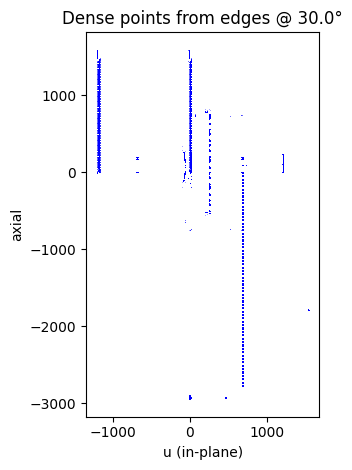

In [43]:
def plot_slice_out_points(slice_out, *, point_size=0.5):
    """
    Plot the dense point chains stored in pts_lists.
    Each pts_list is a list of 2D points (Pt2).
    """
    comps = slice_out.get("components", {})
    if not comps:
        print("No components found.")
        return

    angle_to_points = {}
    for label, comp in comps.items():
        iba = comp.get("instances_by_angle", {})
        for ang_key, inst_list in iba.items():
            ang = float(ang_key)
            for inst in inst_list:
                chains = inst.get("pts_lists", [])
                if not chains:
                    continue
                for chain in chains:
                    angle_to_points.setdefault(ang, []).extend(chain)

    for ang in sorted(angle_to_points.keys()):
        pts = angle_to_points[ang]
        xs = [p[0] for p in pts]
        ys = [p[1] for p in pts]

        plt.figure()
        plt.scatter(xs, ys, s=point_size, c='blue', marker='.', linewidths=0)
        plt.gca().set_aspect("equal", adjustable="box")
        plt.title(f"Dense points from edges @ {ang:.1f}°")
        plt.xlabel("u (in-plane)")
        plt.ylabel("axial")
        plt.tight_layout()
        plt.show()

plot_slice_out_points(slice_out)

In [63]:
def edges_to_pts_chains_strict(
    edges: List[Part.Edge],
    angle_deg: float,
    axis: str = "Y",
    deflection: float = 1e-6,
    placement: Optional[FreeCAD.Placement] = None,
) -> Tuple[List[List[Pt2]], List, Optional[Dict[str, Any]]]:
    """
    Convert section edges into ordered point chains.

    - Edges are grouped into topologically connected wires via Part.sortEdges().
    - Each edge is discretised with the given deflection.
    - **If placement is provided**, it is applied to every discretised 3D point
      before projection. This ensures points are in global coordinates even
      when the edge geometry is still local (e.g., after transformShape).
    - Points are then projected to 2D.
    - Returns (list_of_point_chains, [], None) – compatible with your existing pipeline.
    """
    if not edges:
        return [], [], None

    # Pre‑compute transformation matrix from placement (if provided)
    mat = None
    if placement is not None:
        if hasattr(placement, "toMatrix"):
            mat = placement.toMatrix()
        else:
            mat = placement  # caller already passed a matrix

    try:
        wire_groups = Part.sortEdges(edges)
        all_chains: List[List[Pt2]] = []

        for group in wire_groups:
            # Build a wire to verify orientation (optional but robust)
            wire = Part.Wire(group)
            chain_pts: List[Pt2] = []

            for i, e in enumerate(group):
                # Determine correct orientation relative to the wire
                if i == 0:
                    fwd = True
                else:
                    prev_e = group[i-1]
                    prev_end = prev_e.valueAt(prev_e.LastParameter)
                    this_start = e.valueAt(e.FirstParameter)
                    this_end = e.valueAt(e.LastParameter)
                    if prev_end.distanceToPoint(this_start) < 1e-7:
                        fwd = True
                    elif prev_end.distanceToPoint(this_end) < 1e-7:
                        fwd = False
                    else:
                        fwd = True  # fallback

                # Discretize the edge (3D points)
                verts = e.discretize(Deflection=deflection)

                # Apply placement matrix if given (transform points to global coordinates)
                if mat is not None:
                    verts = [mat.multiply(v) for v in verts]

                # Project each vertex to 2D
                pts_2d = [_v3_to_2d_in_vertical_plane(v, angle_deg, axis) for v in verts]

                # Reverse if edge is traversed backwards
                if not fwd:
                    pts_2d.reverse()

                # Avoid duplicate point at the shared vertex
                if chain_pts and pts_2d and _close_enough(chain_pts[-1], pts_2d[0], 1e-7):
                    pts_2d = pts_2d[1:]

                chain_pts.extend(pts_2d)

            all_chains.append(chain_pts)

        return all_chains, [], None

    except Exception as ex:
        print(f"edges_to_pts_chains_strict failed: {ex}")
        return [], [], {
            "type": type(ex).__name__,
            "message": str(ex),
            "traceback": traceback.format_exc(limit=10),
        }
def slice_csv_targets_per_angle(
    *,
    root: Any,
    targets: List[ComponentSpec],
    resolved: Dict[str, List[str]],
    angles_deg: List[float],
    axis: str = "Y",
    origin: Tuple[float, float, float] = (0.0, 0.0, 0.0),
    tol: float = 1e-7,
    deflection: float = 1e-6,
) -> Dict[str, Any]:
    """
    Slice all CSV‑marked mesh targets, for multiple angles.

    Returns a structured dictionary containing for each component / angle / instance:
      - dense point chains (pts_lists) from edge discretisation
      - compact drawing instructions (instr_lists) via wire_to_pts_instructions_strict
      - placement matrix (flattened) for debugging
    """
    spec_index = _build_spec_index(targets)

    out: Dict[str, Any] = {
        "axis": str(axis),
        "angles_deg": [float(a) for a in angles_deg],
        "components": {},
    }

    for sub_label, subpaths in (resolved or {}).items():
        if not subpaths:
            continue

        spec = spec_index.get(sub_label)
        bc = (spec.bc if spec else "NA") or "NA"

        comp_entry = {
            "component": sub_label,
            "bc": bc,
            "axis": str(axis),
            "angles_deg": [float(a) for a in angles_deg],
            "instances_by_angle": {},
        }

        for ang in angles_deg:
            per_inst_outputs: List[Dict[str, Any]] = []

            for sp in subpaths:
                leaf_paths = expand_to_leaf_geometry_paths(root, sp)
                for sp2 in leaf_paths:
                    # ---- 1. Slice instance & get placement matrix ----
                    edges, matrix = slice_paths_with_vertical_plane(
                        root=root,
                        subpath=sp2,
                        angle_deg=float(ang),
                        origin=origin,
                        axis=axis,
                        tol=float(tol),
                    )

                    # Convert matrix to Placement (if needed for instruction generation)
                    placement = None
                    if matrix is not None:
                        placement = FreeCAD.Placement(matrix)

                    # ---- 2. Group edges into topological wires ----
                    wire_groups = Part.sortEdges(edges)

                    pts_lists_for_inst: List[List[Pt2]] = []
                    instr_lists_for_inst: List[List[Instr]] = []

                    for group in wire_groups:
                        # Build ordered (edge, fwd) list for this wire
                        ordered_edges: List[Tuple[Part.Edge, bool]] = []
                        for i, e in enumerate(group):
                            if i == 0:
                                fwd = True
                            else:
                                prev_e = group[i-1]
                                prev_end = prev_e.valueAt(prev_e.LastParameter)
                                this_start = e.valueAt(e.FirstParameter)
                                this_end = e.valueAt(e.LastParameter)
                                if prev_end.distanceToPoint(this_start) < 1e-7:
                                    fwd = True
                                elif prev_end.distanceToPoint(this_end) < 1e-7:
                                    fwd = False
                                else:
                                    fwd = True   # fallback
                            ordered_edges.append((e, fwd))

                        # ---- 3. Dense point chain (discretisation) – NOW USES PLACEMENT ----
                        # We can reuse edges_to_pts_chains_strict, or implement directly.
                        # For clarity, we'll call the corrected version.
                        chain_pts, _, _ = edges_to_pts_chains_strict(
                            group,
                            angle_deg=float(ang),
                            axis=axis,
                            deflection=deflection,
                            placement=placement,   # <-- crucial! passes matrix
                        )
                        # edges_to_pts_chains_strict returns a list of chains (one per wire),
                        # but here group is already one wire, so it returns a list with one chain.
                        if chain_pts:
                            pts_lists_for_inst.append(chain_pts[0])

                        # ---- 4. Compact instructions (using placement) ----
                        try:
                            instrs = wire_to_pts_instructions_strict(
                                ordered_edges,
                                angle_deg=float(ang),
                                axis=axis,
                                placement=placement,   # may be None – handled inside
                            )
                            instr_lists_for_inst.append(instrs)
                        except Exception as e:
                            instr_lists_for_inst.append({
                                "error": str(e),
                                "traceback": traceback.format_exc(limit=5)
                            })

                    # ---- 5. Metadata about the instance ----
                    obj_label, obj_name, obj_type = "", "", ""
                    try:
                        o = root.getSubObject(sp2)
                        obj_label = str(_safe(o, "Label", "")) if o else ""
                        obj_name  = str(_safe(o, "Name", "")) if o else ""
                        obj_type  = str(_safe(o, "TypeId", "")) if o else ""
                    except Exception:
                        pass

                    # Flatten matrix for JSON‑friendly output
                    mat_list = None
                    if matrix is not None:
                        mat_list = [
                            matrix.A11, matrix.A12, matrix.A13, matrix.A14,
                            matrix.A21, matrix.A22, matrix.A23, matrix.A24,
                            matrix.A31, matrix.A32, matrix.A33, matrix.A34,
                            matrix.A41, matrix.A42, matrix.A43, matrix.A44,
                        ]

                    per_inst_outputs.append({
                        "subpath": sp2,
                        "object_name": obj_name,
                        "object_label": obj_label,
                        "object_type": obj_type,
                        "placement_matrix": mat_list,        # for debugging
                        "pts_lists": pts_lists_for_inst,
                        "instr_lists": instr_lists_for_inst,
                    })

            comp_entry["instances_by_angle"][str(float(ang))] = per_inst_outputs

        out["components"][sub_label] = comp_entry

    return out

In [64]:
slice_out = slice_csv_targets_per_angle(
    root=root,
    targets=targets,
    resolved=resolved,
    angles_deg=[30.0],           # you can add more angles
    axis="Y",
    origin=(0.0, 0.0, 0.0),
    tol=1e-12,
    deflection=1e-6               # discretisation step for dense points
)

In [65]:
import matplotlib.pyplot as plt

def plot_comparison(slice_out: Dict[str, Any], angle: float, figsize: Tuple[int,int] = (14,6),
                    dense_point_size: float = 0.5, instr_point_size: float = 10.0) -> None:
    """
    Plot dense points (left) and instruction start points (right) for a given angle.
    """
    data = extract_points_from_slice_out(slice_out)
    if angle not in data:
        print(f"Angle {angle} not found in slice_out.")
        return

    dense_pts, instr_pts = data[angle]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    # Left: dense points
    if dense_pts:
        xs = [p[0] for p in dense_pts]
        ys = [p[1] for p in dense_pts]
        ax1.scatter(xs, ys, s=dense_point_size, c='blue', alpha=0.5, edgecolors='none')
    ax1.set_title(f"Dense points (all chains) @ {angle}°")
    ax1.set_xlabel("u")
    ax1.set_ylabel("axial")
    ax1.set_aspect("equal", adjustable="box")
    ax1.grid(True, linestyle='--', alpha=0.3)

    # Right: instruction start points
    if instr_pts:
        xs = [p[0] for p in instr_pts]
        ys = [p[1] for p in instr_pts]
        ax2.scatter(xs, ys, s=instr_point_size, c='red', alpha=0.7, edgecolors='none')
    ax2.set_title(f"Instruction start points @ {angle}°")
    ax2.set_xlabel("u")
    ax2.set_ylabel("axial")
    ax2.set_aspect("equal", adjustable="box")
    ax2.grid(True, linestyle='--', alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print some statistics
    print(f"Dense points count: {len(dense_pts)}")
    print(f"Instruction start points count: {len(instr_pts)}")
    if dense_pts and instr_pts:
        import numpy as np
        avg_dense = (np.mean([p[0] for p in dense_pts]), np.mean([p[1] for p in dense_pts]))
        avg_instr = (np.mean([p[0] for p in instr_pts]), np.mean([p[1] for p in instr_pts]))
        print(f"Avg dense : ({avg_dense[0]:.6f}, {avg_dense[1]:.6f})")
        print(f"Avg instr : ({avg_instr[0]:.6f}, {avg_instr[1]:.6f})")
        print(f"Difference: ({avg_instr[0]-avg_dense[0]:.6f}, {avg_instr[1]-avg_dense[1]:.6f})")

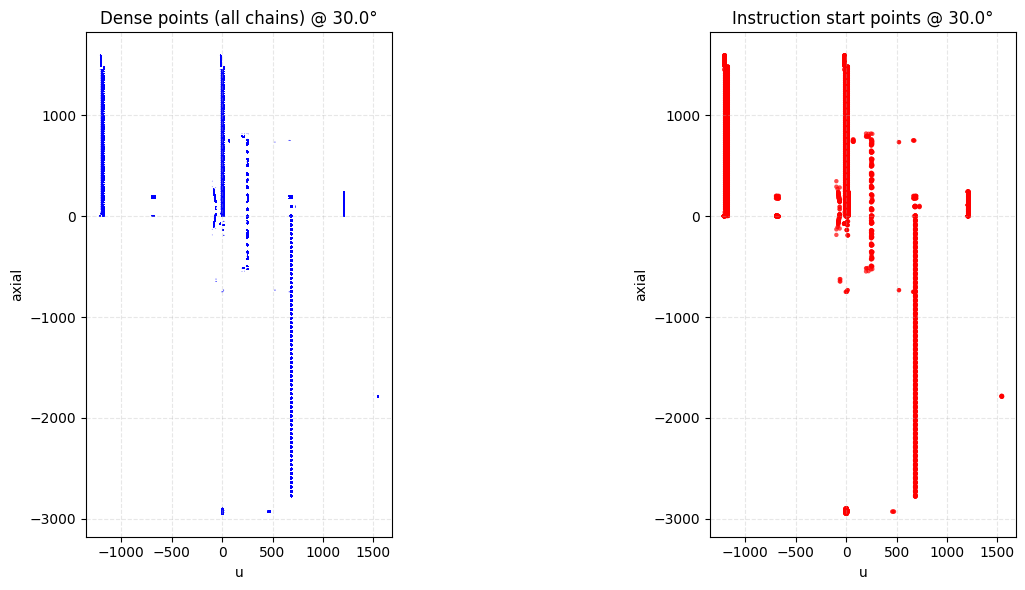

Dense points count: 3338404
Instruction start points count: 6816
Avg dense : (182.737424, -15.709822)
Avg instr : (15.085501, 153.502543)
Difference: (-167.651923, 169.212366)


In [66]:
plot_comparison(slice_out, angle=30.0)